# 2022. 03. 23. Temporal noise

## testing measurement analysis based on https://onlinelibrary.wiley.com/doi/10.1002/smll.202107220

Remarks:
these measurements were not planned to be used in a similar analysis, but might be a good basis in trying out the analysis method

In [1]:
from mcbj import *
from tqdm.notebook import tqdm
import filter_traces
import plots
import pandas as pd

date = "22_03_23"
sample_rate = 50_000
home_folder = Path(f"D:/BJ_Data/{date}")
import numpy as np
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import LogNorm
import matplotlib.pylab as pl
import scipy.signal

import warnings
warnings.filterwarnings('error')

In [2]:
def even_ext(arr, n):
    left_ext = arr[n:0:-1]
    right_ext = arr[-n-1:-1][::-1]
    return np.concatenate((left_ext, arr, right_ext))

In [3]:
def mov_avg(arr, win_size, step_size, avg_type: callable = np.mean):
    arr_ext = even_ext(arr, n=step_size)
    arr_mov_avg = np.zeros(arr_ext.shape[0]//step_size)
    for i in range(len(arr_mov_avg)):
        arr_mov_avg[i] = avg_type(arr_ext[i*step_size : (i*step_size) + win_size])
        
    return arr_mov_avg

In [4]:
def log_avg(arr):
    return 10**np.mean(np.log10(arr))

In [5]:
def cut_to_same_len(x, y):
    to_len = min(list(map(len, x)))
    x_new = []
    y_new = []
    
    for i in range(len(x)):
        differ = len(x[i])-to_len
        if differ > 0:
            x_new.append(x[i][differ//2 : -differ//2])
            y_new.append(y[i][differ//2 : -differ//2])
        else:
            x_new.append(x[i])
            y_new.append(y[i])
    return np.array(x_new), np.array(y_new)

<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>

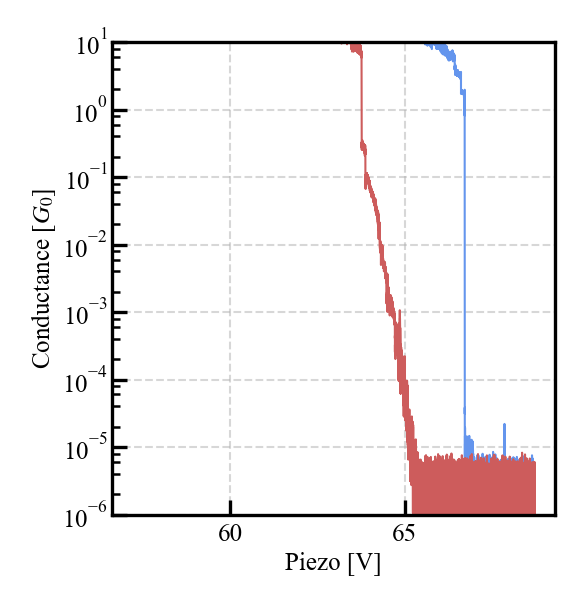

In [6]:
trace_pair = TracePair(2, load_from=home_folder)
trace_pair.plot_trace_pair(dpi=300)

In [30]:
piezo_rate = trace_pair.rate

# Measurements with BPY

In [7]:
hist = Histogram(home_folder, start_trace=36001, end_trace=44000)

hist.calc_stats(align_at=0.5, range_pull=(-0.6, 0.5), range_push=(-1, 2), xbins_pull=250, xbins_push=400,
                plateau_length_bins=100)

Processing break junction files:   0%|          | 0/81 [00:00<?, ?it/s]

Pull 2D histogram created from 7994 traces
Push 2D histogram created from 8000 traces


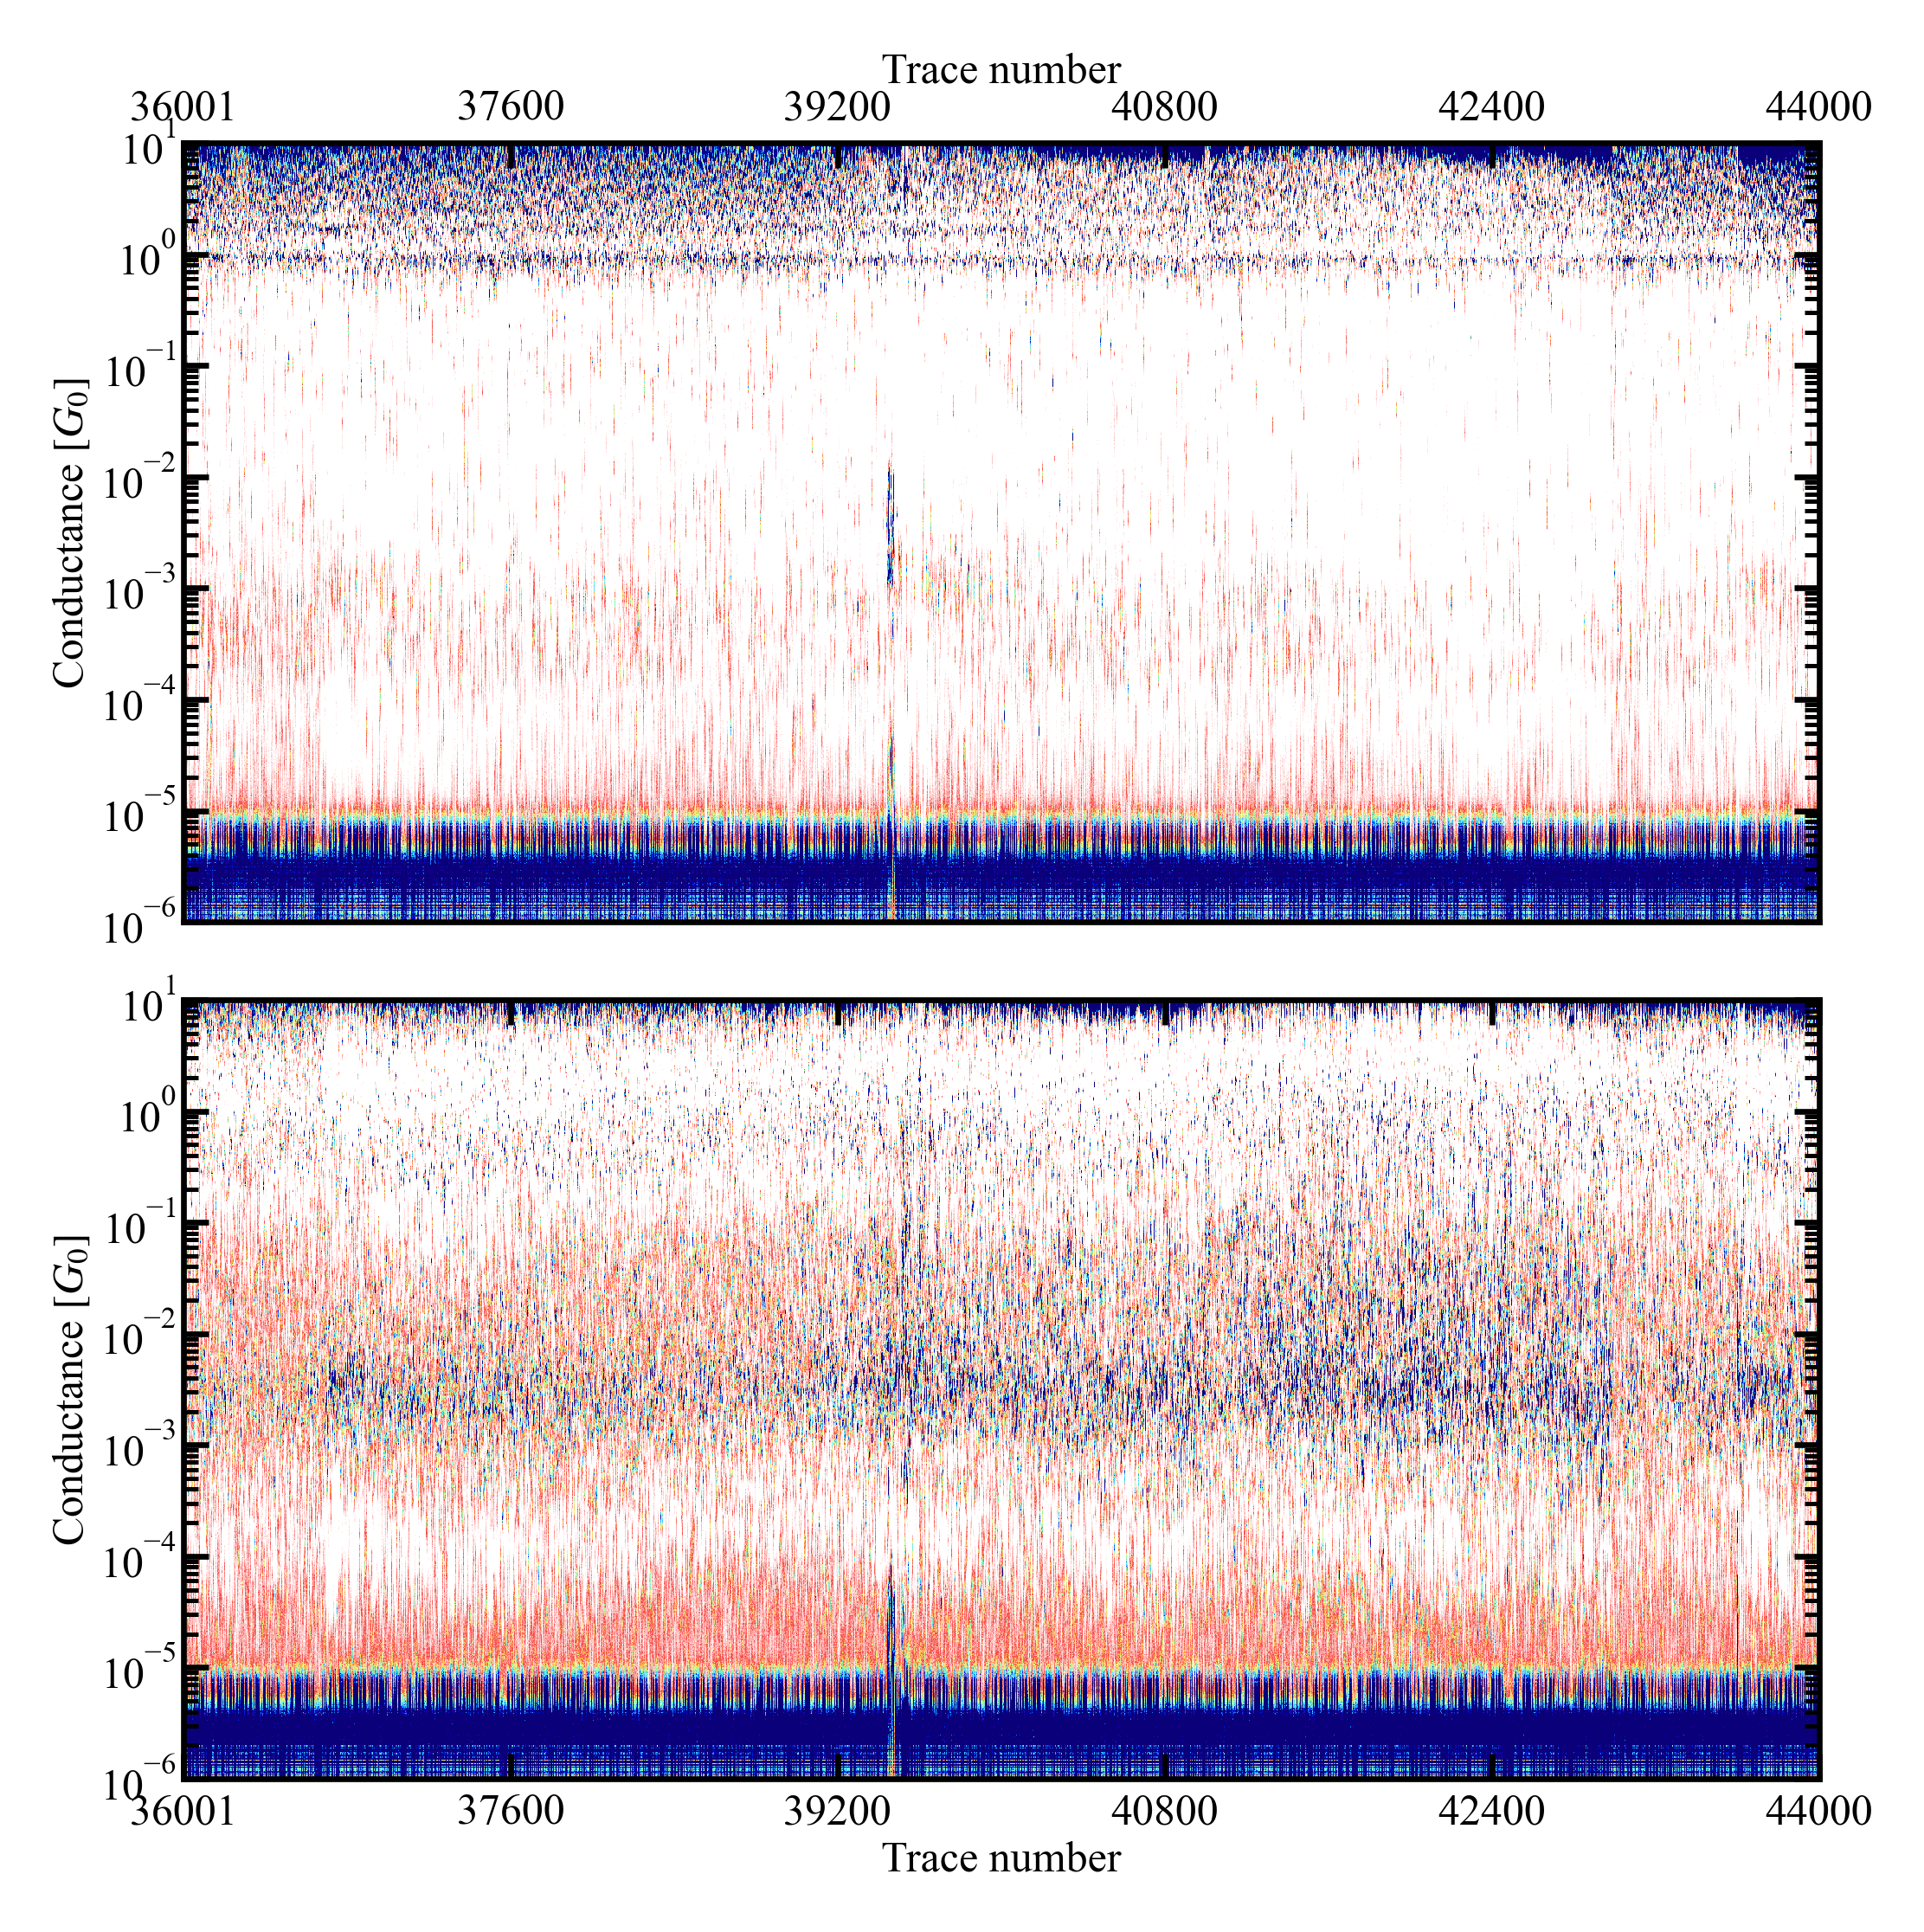

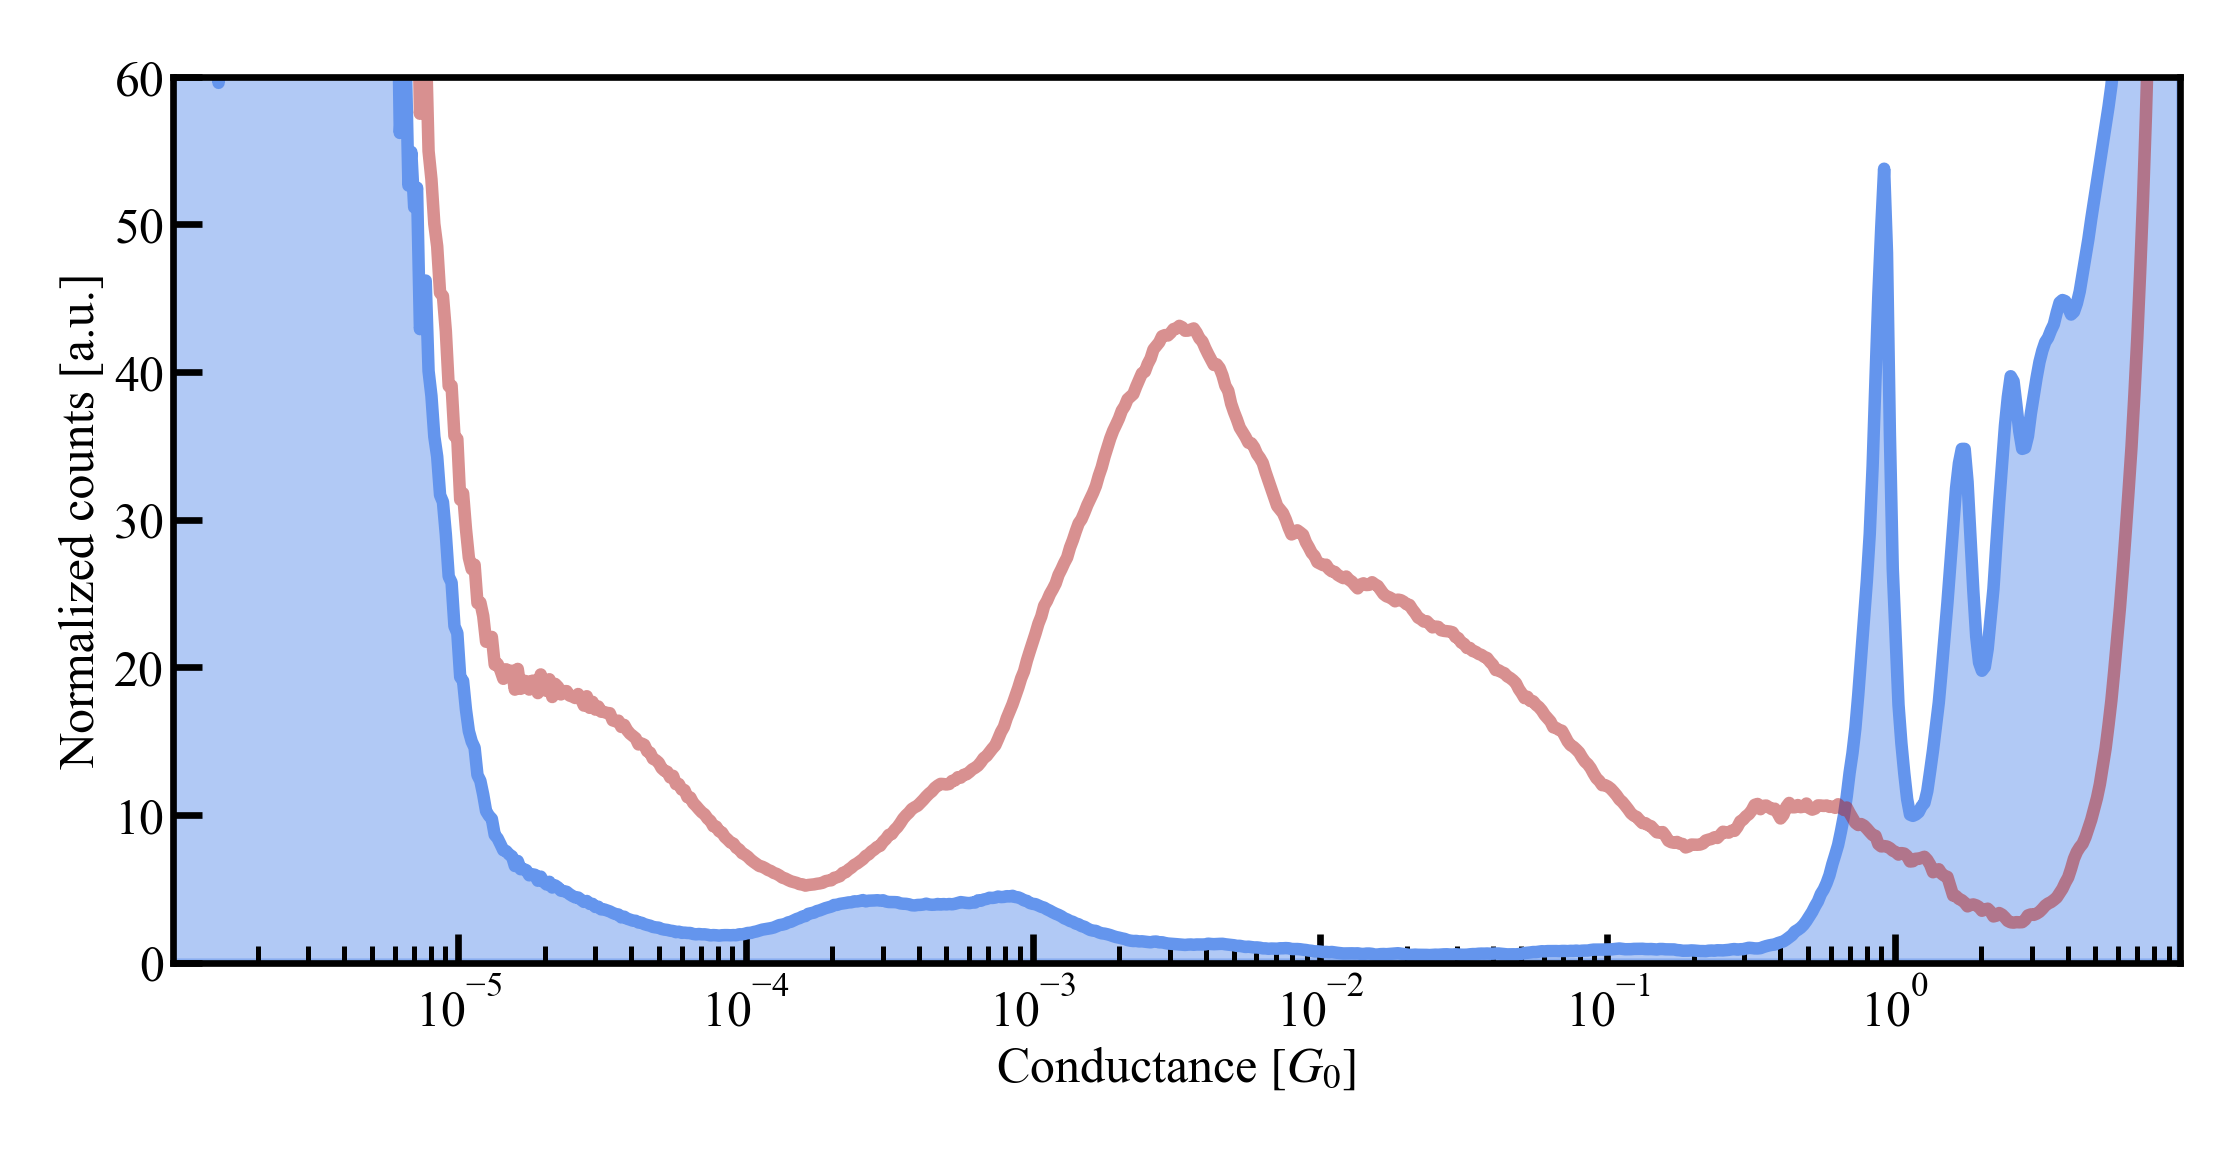

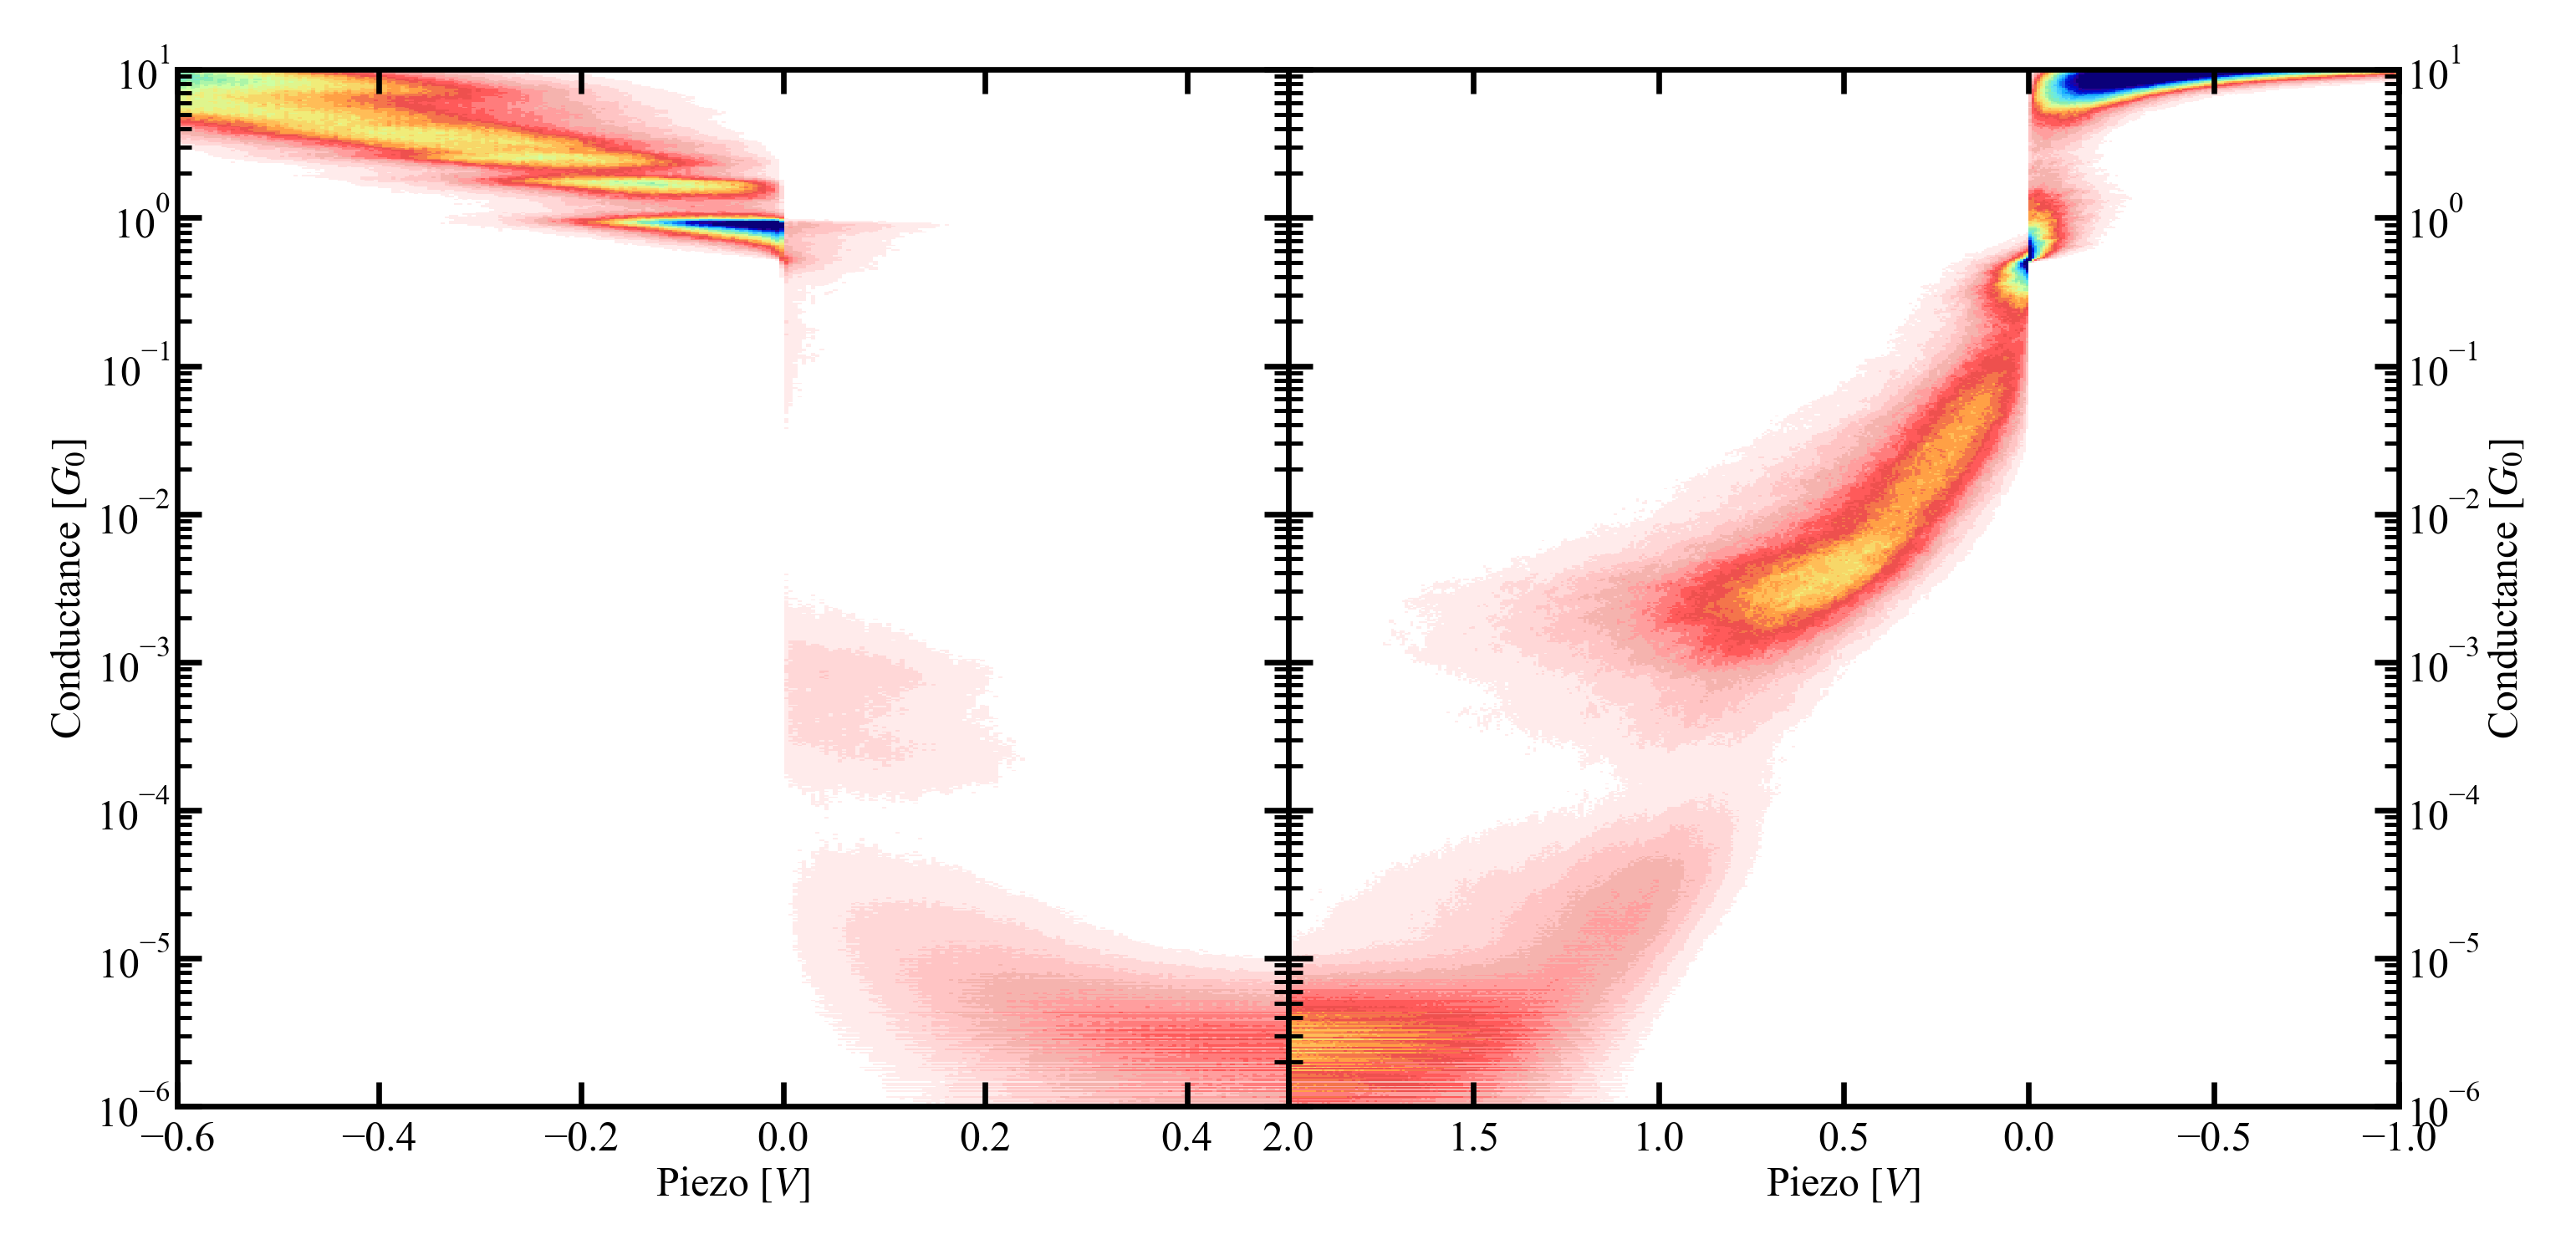

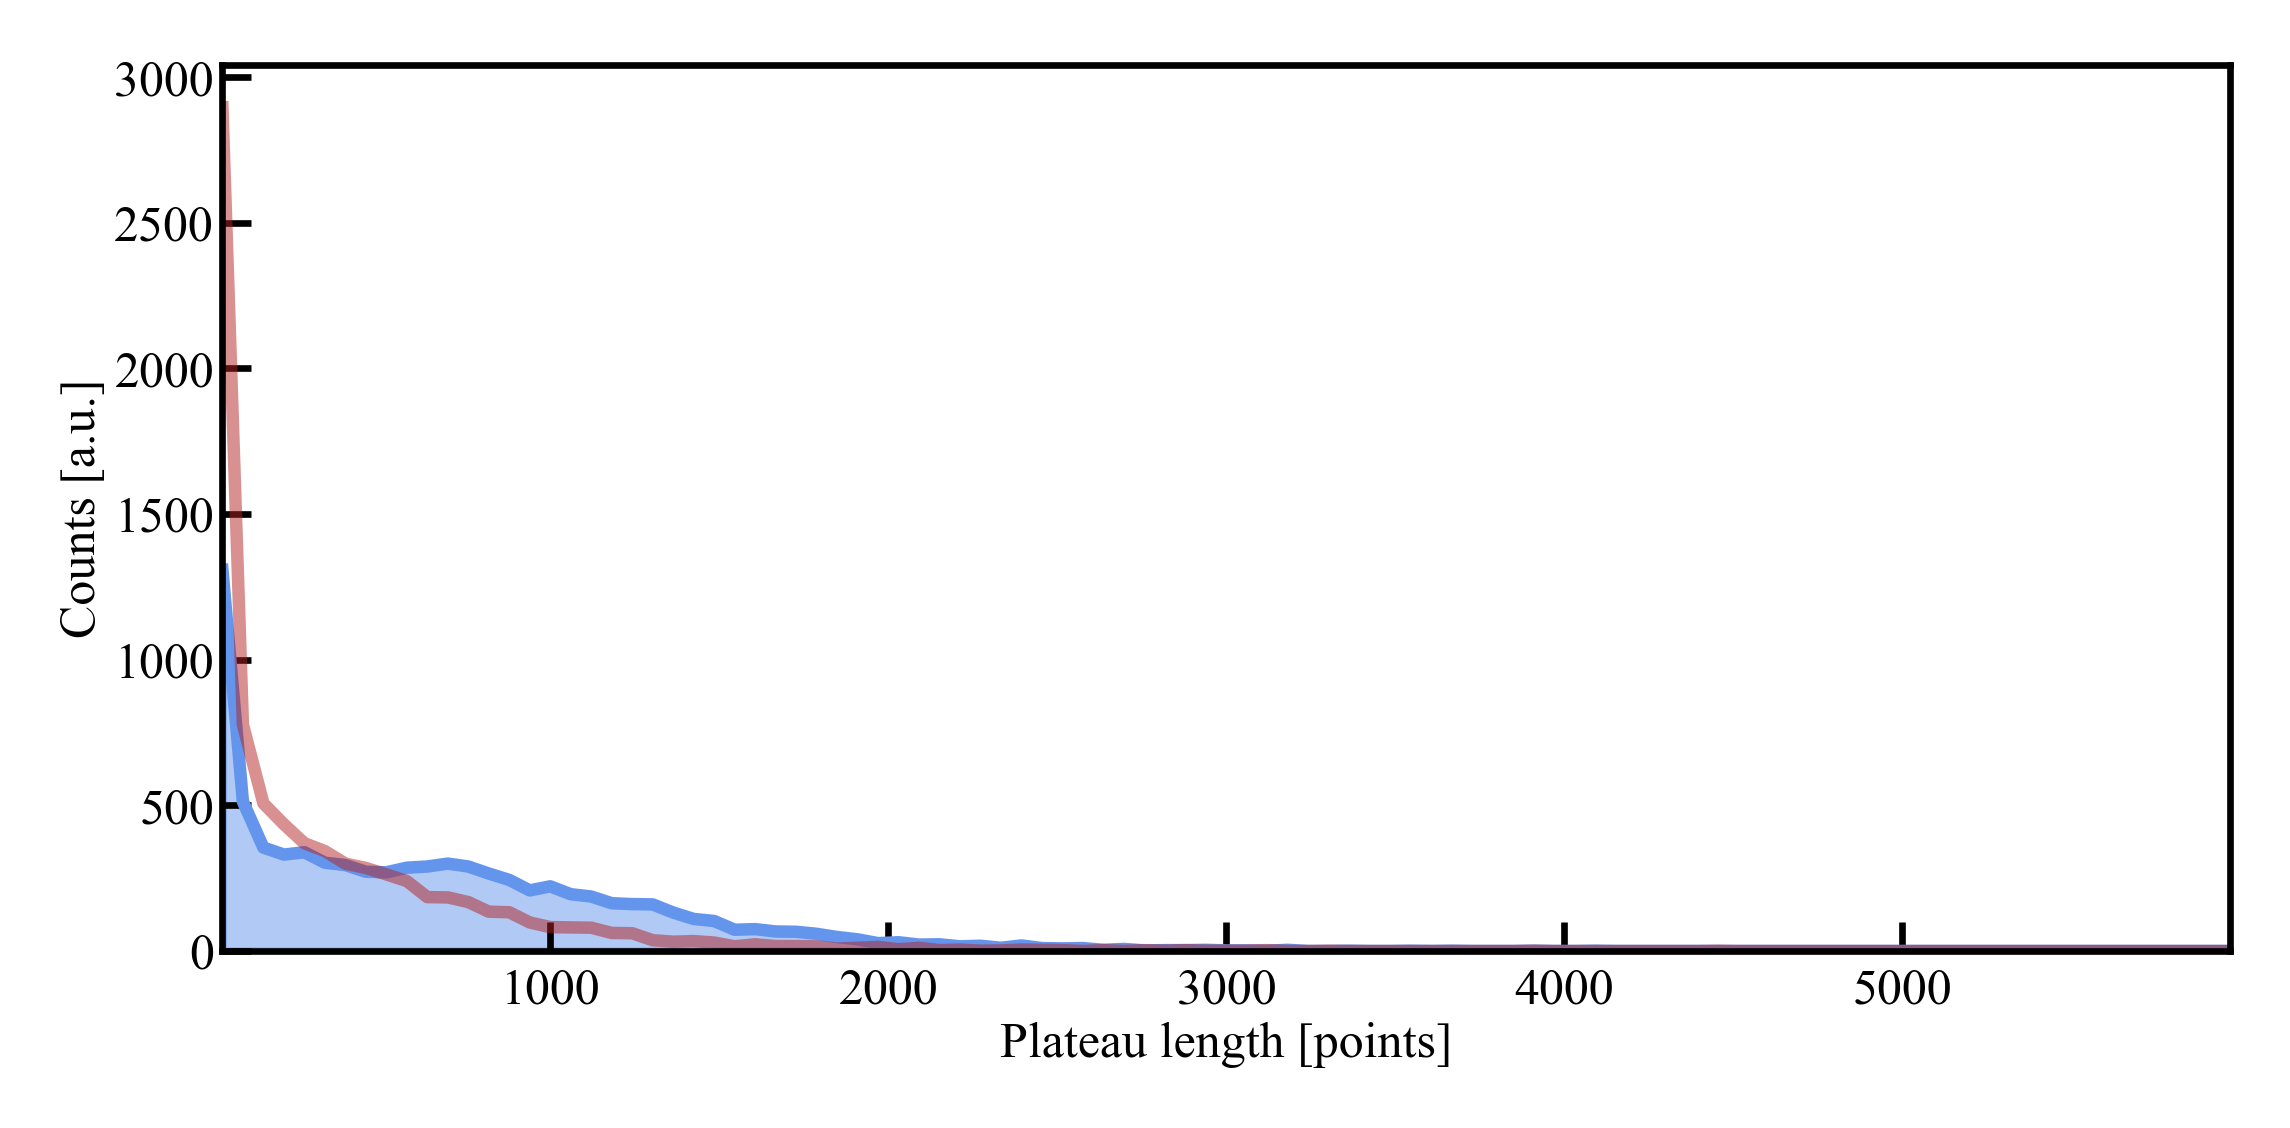

In [8]:
ax_temp_pull, ax_temp_push = hist.plot_temporal_hist(vmax=100)
ax_temp_pull.set_xticks(np.linspace(0, 8_000, 6).astype(int))
ax_temp_pull.set_xticklabels(np.linspace(36_001, 44_000, 6).astype(int))
ax_temp_push.set_xticks(np.linspace(0, 8_000, 6).astype(int))
ax_temp_push.set_xticklabels(np.linspace(36_001, 44_000, 6).astype(int))
ax_1d = hist.plot_hist_1d(ylims=(0, 60))
ax_pull, ax_push = hist.plot_hist_2d_both(vmax=10_000)
ax_plat = hist.plot_plateau_length_hist()

## Filter traces based on molecular plateau length

In [9]:
hist.calc_stats(align_at=0.5, range_pull=(-0.6, 0.5), range_push=(-1, 2), xbins_pull=250, xbins_push=400,
                plateau_length_bins=100)

Processing break junction files:   0%|          | 0/81 [00:00<?, ?it/s]

Pull 2D histogram created from 7994 traces
Push 2D histogram created from 8000 traces


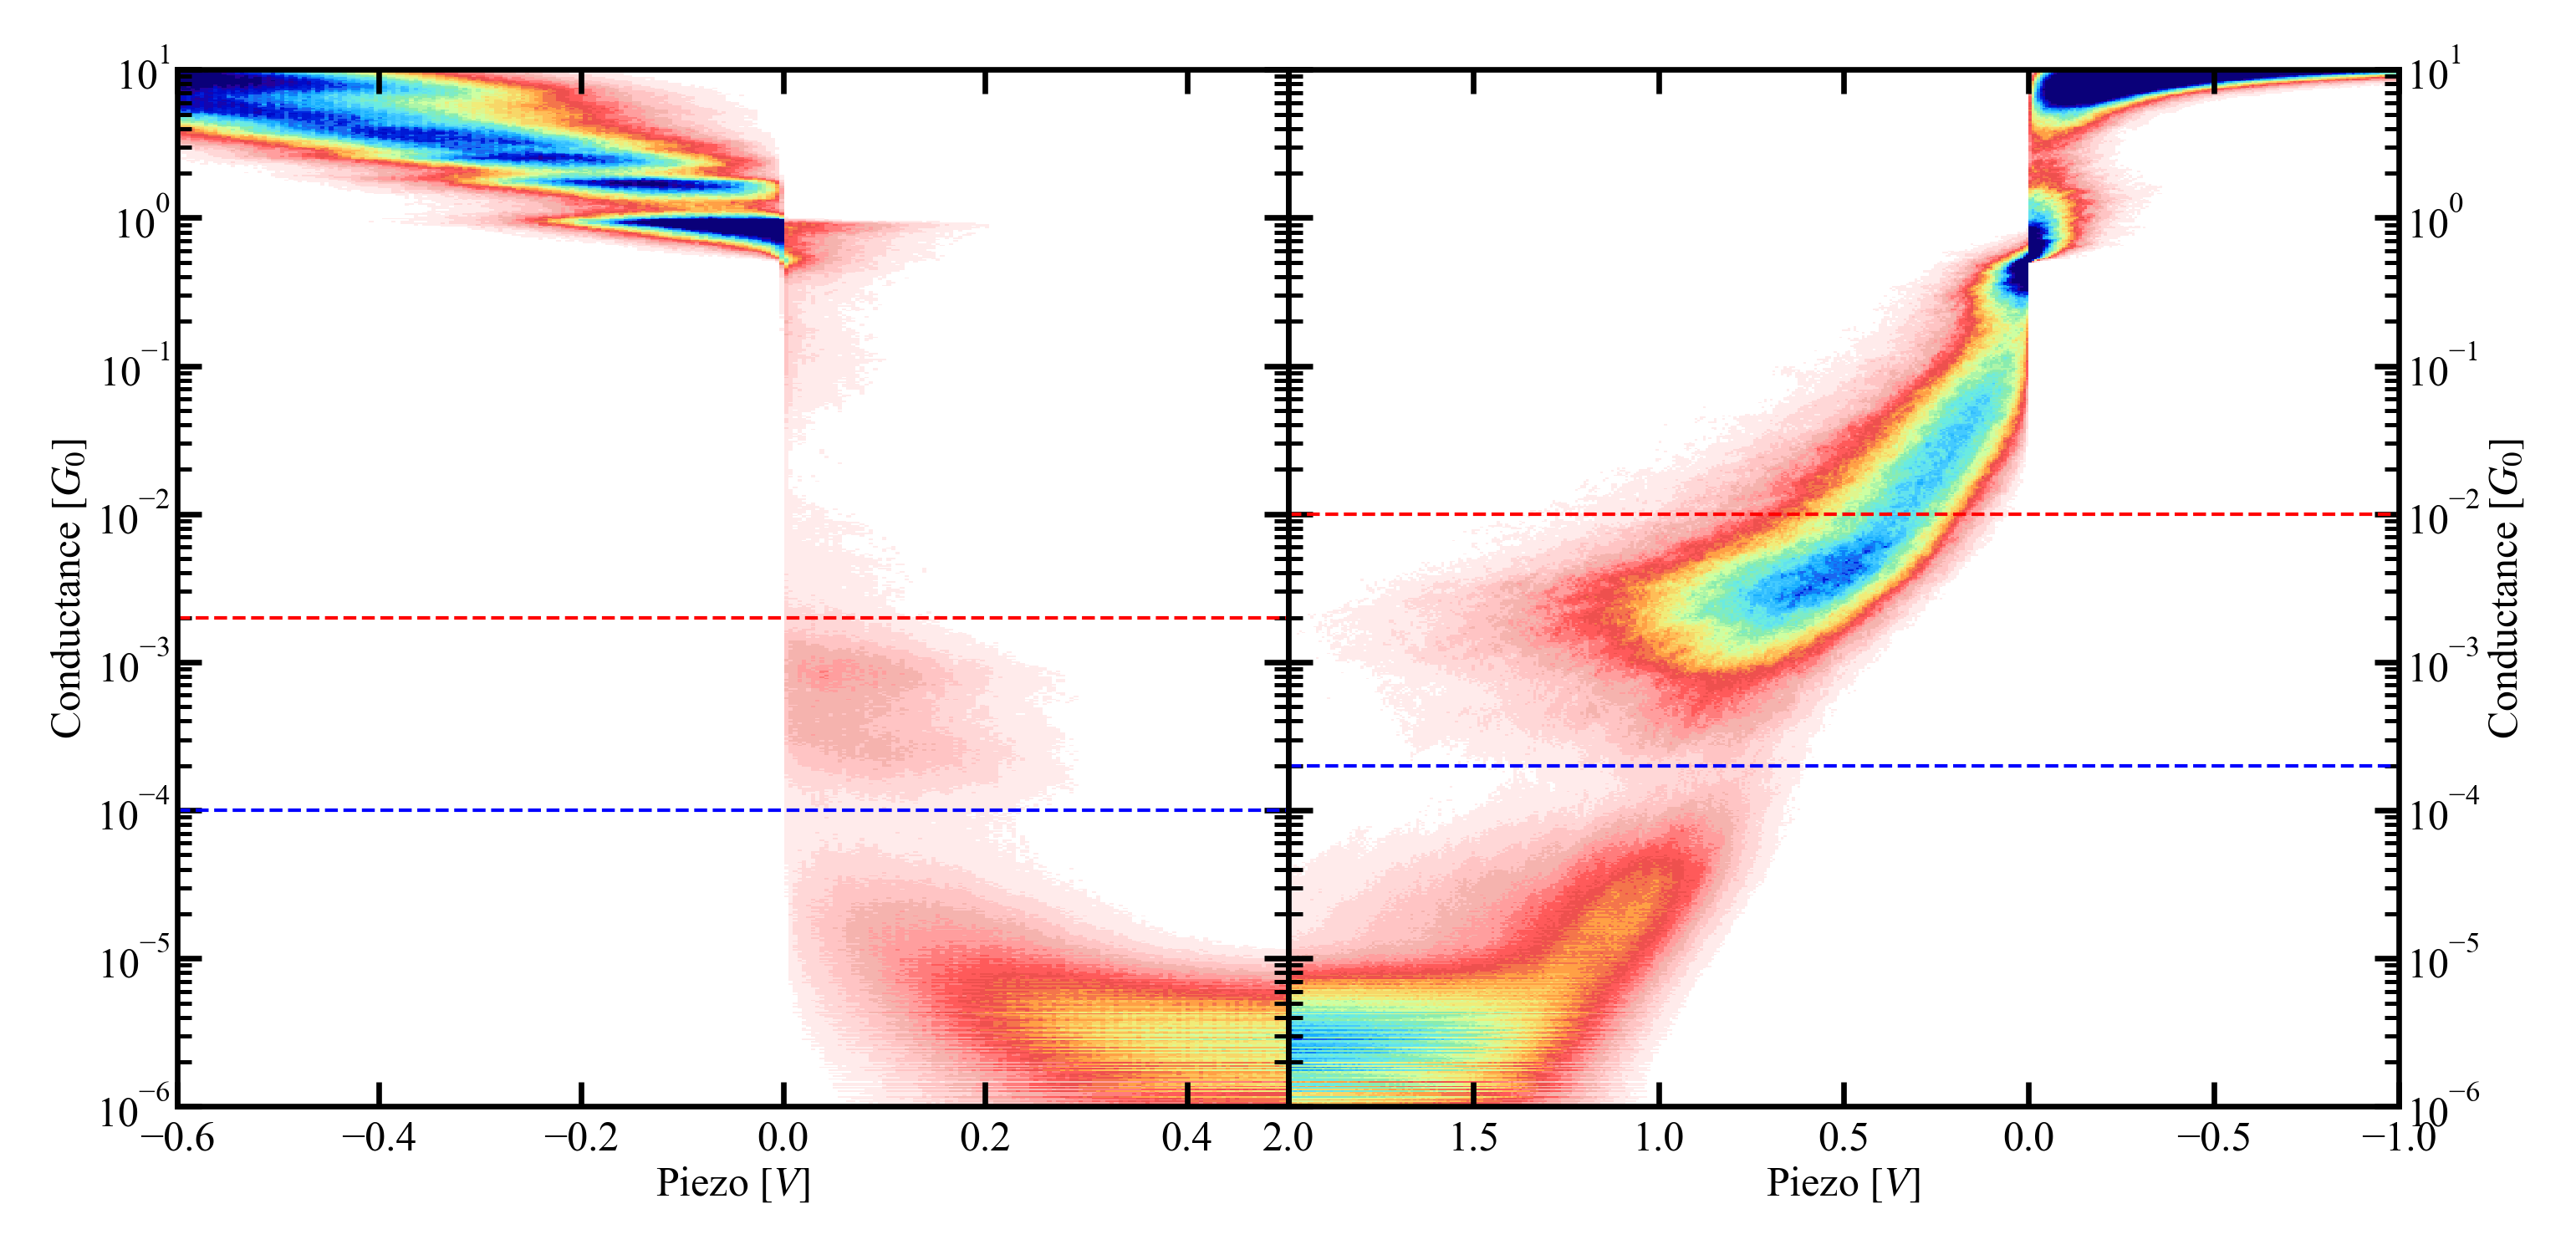

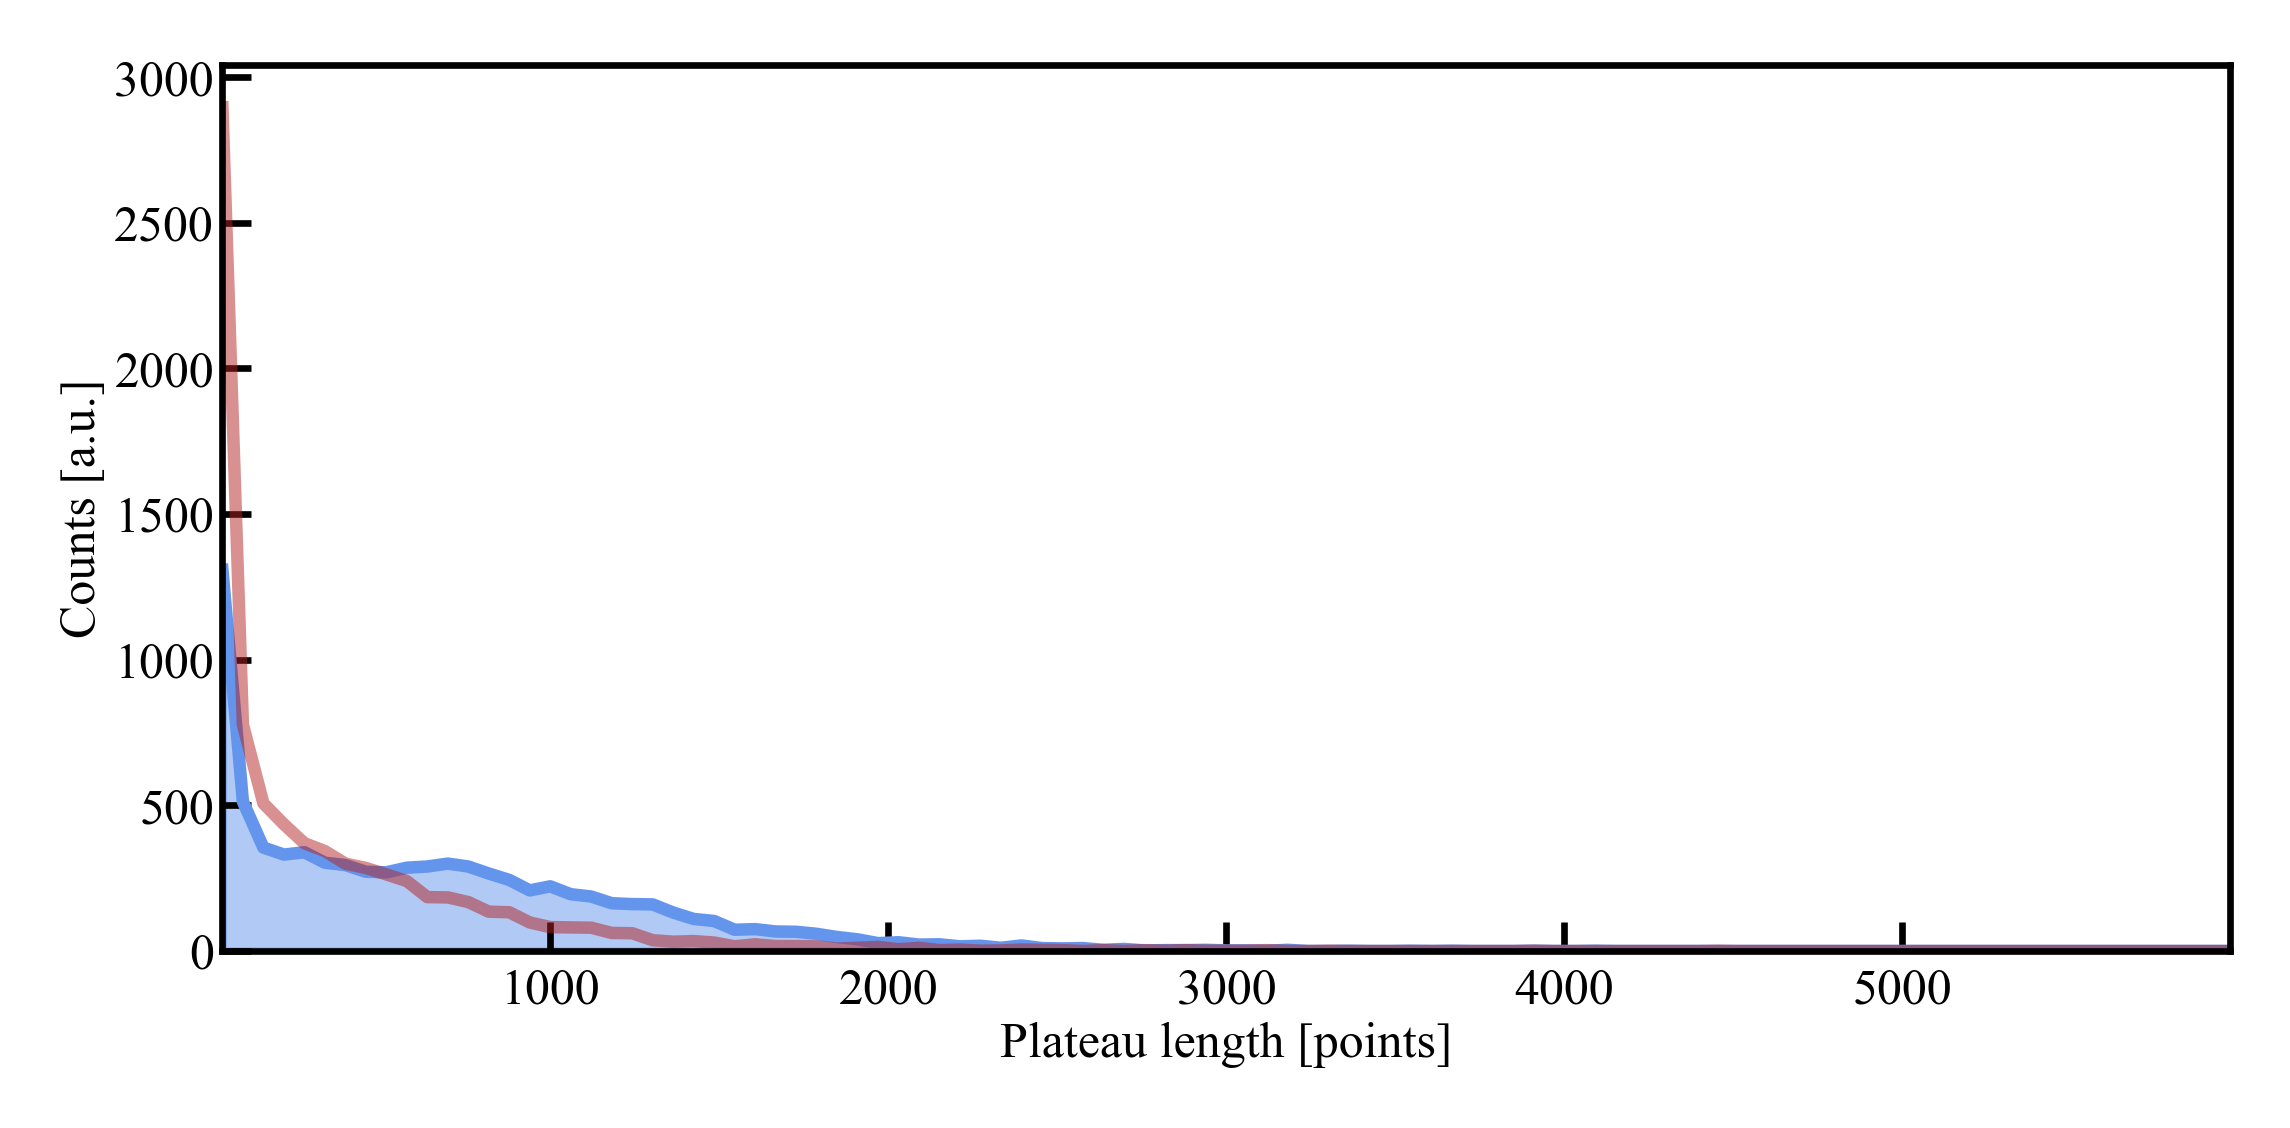

In [10]:
ax_pull, ax_push = hist.plot_hist_2d_both(vmax=10_000)
ax_pull.axhline(1e-4, ls='--', lw=0.5, c='b')
ax_pull.axhline(2e-3, ls='--', lw=0.5, c='r')
ax_push.axhline(2e-4, ls='--', lw=0.5, c='b')
ax_push.axhline(1e-2, ls='--', lw=0.5, c='r')
ax_plat = hist.plot_plateau_length_hist()

We need traces with sufficiently long plateau length in the molecular region, for this I plot the plateau length histograms for the plateaus in the molecular conductance range defined as (1e-4, 2e-3) for pull, (2e-4, 1e-2) for the push traces.

In [11]:
hist.calc_plateau_lengths(low_bound_pull=1e-4, high_bound_pull=2e-3,
                          low_bound_push=2e-4, high_bound_push=1e-2)

Calculating plateau length histogram:   0%|          | 0/81 [00:00<?, ?it/s]

In [12]:
hist.calc_plateau_length_hist()

(0, 23000)


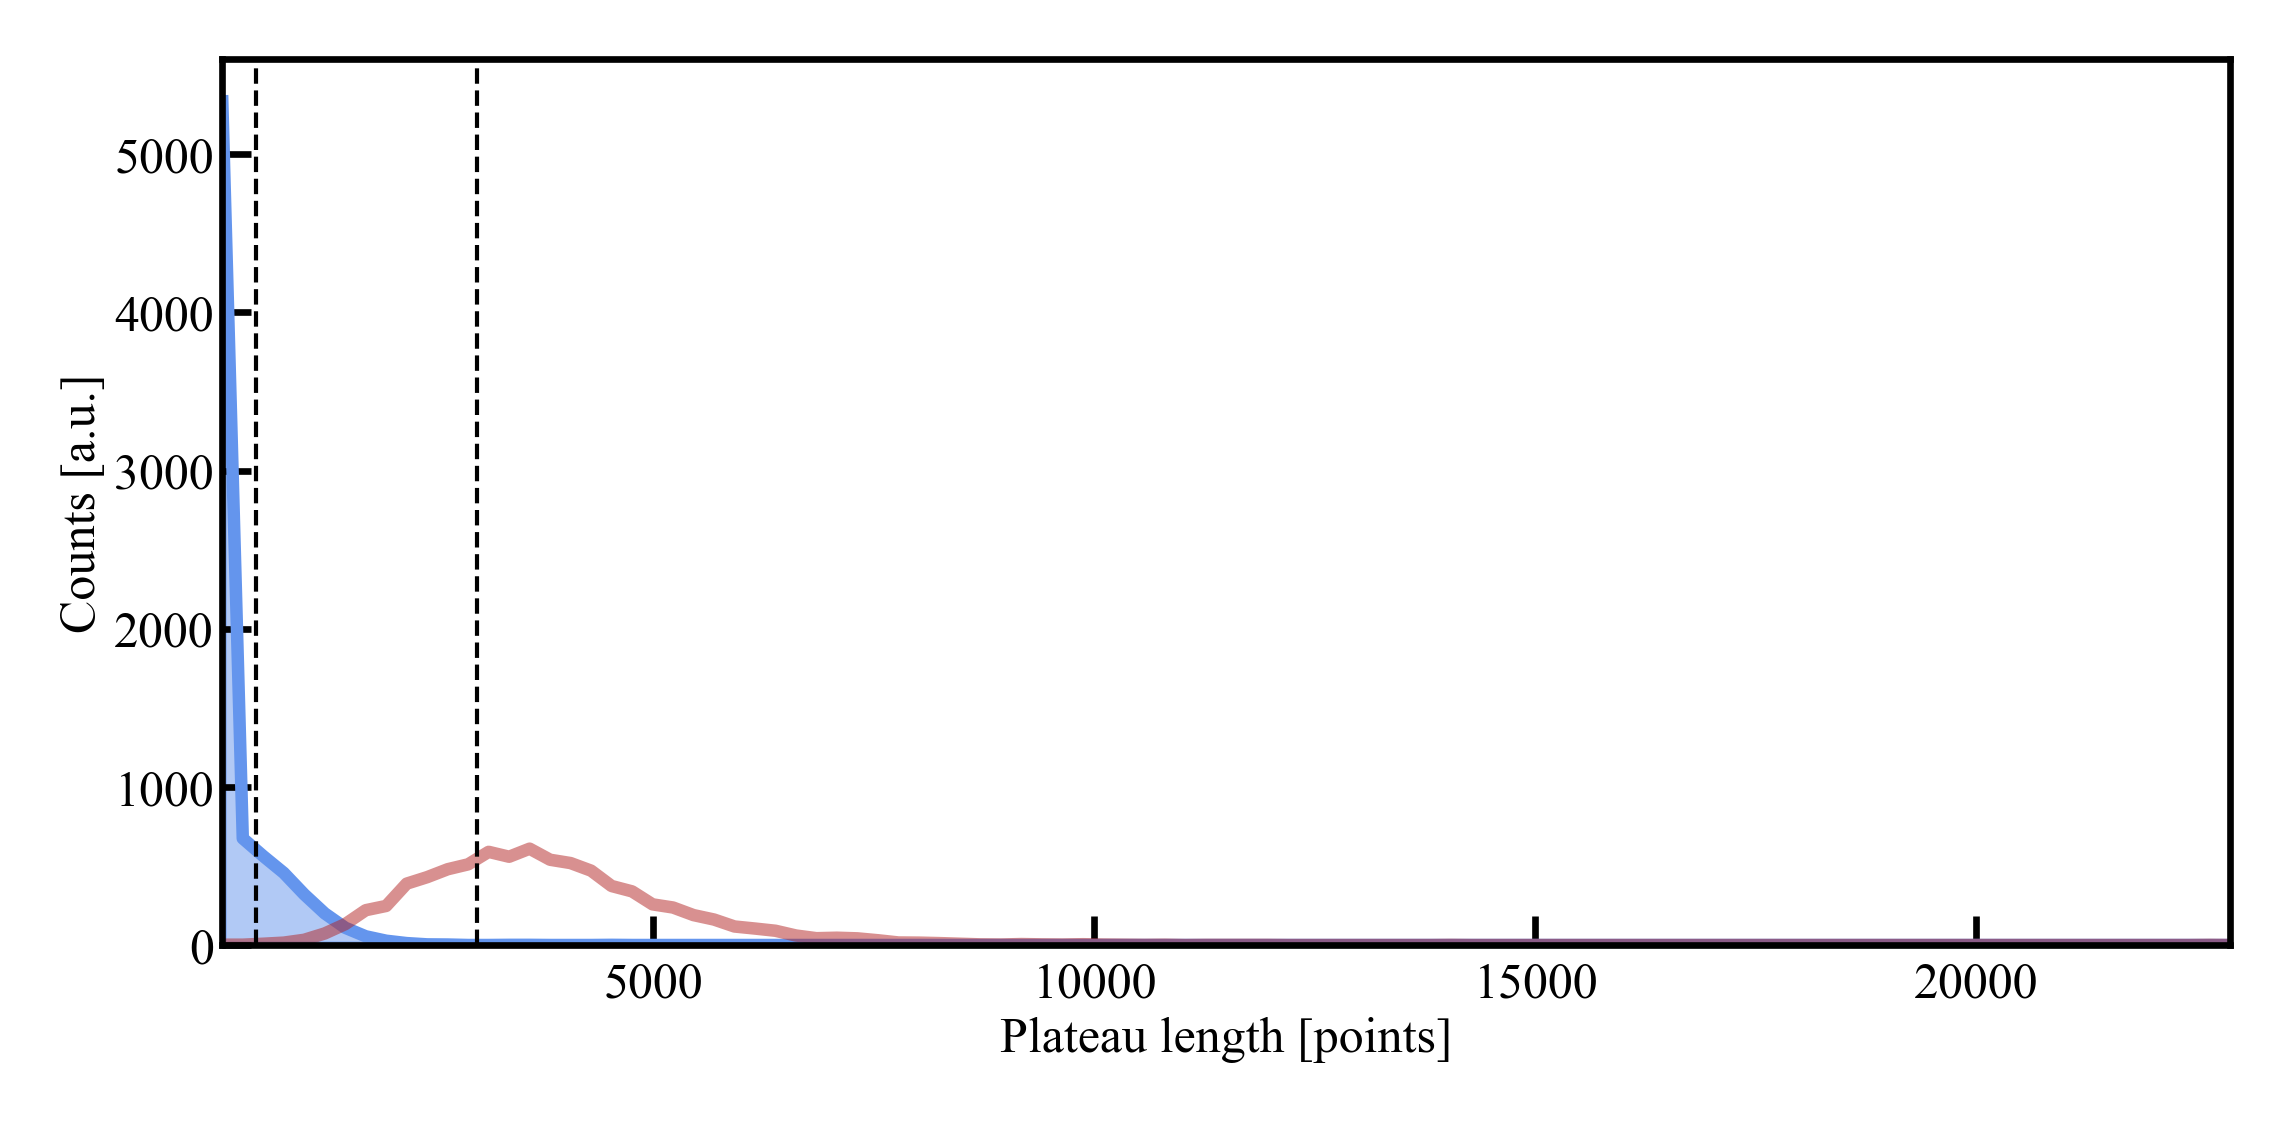

In [13]:
ax_plat = hist.plot_plateau_length_hist()
ax_plat.axvline(3000, ls='--', lw=0.5, c='k')

ax_plat.axvline(500, ls='--', lw=0.5, c='k')

Based on the plot and the necessary number of points I choose a minimal plateau length of 3000 points so I have traces that have long molecular plateaus but I don't lose too much data by discarding too many traces.

In [14]:
hist.plateau_length_pull[hist.plateau_length_pull > 1500].shape  # 30 ms

(157,)

In [15]:
hist.plateau_length_push[hist.plateau_length_push > 1500].shape

(7827,)

In [8]:
chosen = filter_traces.filter_bj(folder=home_folder, start_trace=36001, end_trace=44000,
                                 filter_condition=filter_traces.check_plateau_length, min_length=1500,
                                 low_bound_pull=1e-4, high_bound_pull=2e-3,
                                 low_bound_push=2e-4, high_bound_push=1e-2)

In [9]:
print('Number of chosen pull traces:')
print(chosen[0].shape[0])
print('Number of chosen push traces:')
print(chosen[1].shape[0])

Number of chosen pull traces:
157
Number of chosen push traces:
7827


### Spectrogram for a single trace

41758


<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>

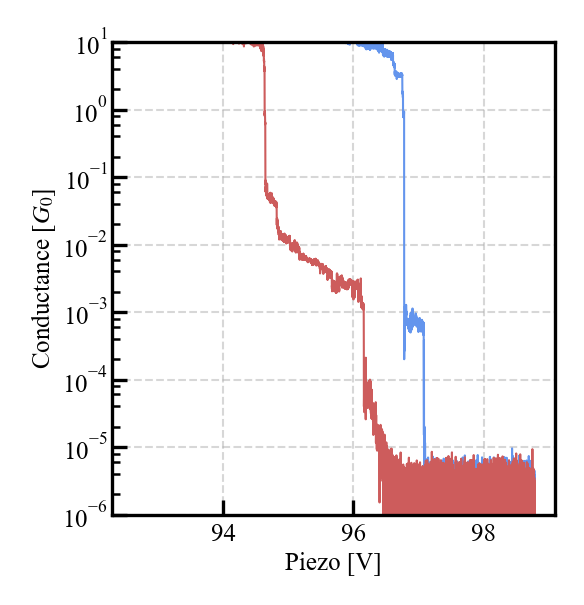

In [18]:
which_trace = np.random.choice(chosen[0], 1)[0]
print(which_trace)
trace_pair = TracePair(which_trace, load_from=home_folder)
trace_pair.plot_trace_pair(dpi=300)

## Align traces at $0.5\;G_{0}$

In [28]:
cutoffs_pull = []
cutoffs_push = []

aligned_cond_pull = []
aligned_piezo_pull = []

aligned_cond_push = []
aligned_piezo_push = []

selected_pull = chosen[0]
selected_push = chosen[1]

print(f'pull {selected_pull.shape}')
print(f'push {selected_push.shape}')

for trace in tqdm(selected_pull):
    trace_pair = TracePair(trace, load_from=home_folder)
    try:
#         cutoff = [np.where(trace_pair.conductance_pull > 10)[0][-1], np.where(trace_pair.conductance_pull < 1e-5)[0][0]]
#         cutoffs_pull.append(cutoff)
        x_aligned, y_aligned = utils.align_trace(x=trace_pair.piezo_pull,
                                                 y=trace_pair.conductance_pull,
                                                 align_value=1e-5, xrange=(-0.6, 0.2))
        if len(y_aligned) > 3000:
            aligned_piezo_pull.append(x_aligned)
            aligned_cond_pull.append(y_aligned)
        else:
            selected_pull = np.delete(selected_pull, np.where(selected_pull==trace_pair.trace_num))
#         cutoff = np.where(trace_pair.conductance_push > 10)[0][0]
#         cutoffs.append(cutoff)
    except IndexError:
        selected_pull = np.delete(selected_pull, np.where(selected_pull==trace_pair.trace_num))
        print(f'IndexError at trace {trace_pair.trace_num}')

# for trace in tqdm(selected_push):
#     trace_pair = TracePair(trace, load_from=home_folder)
#     try:
# #         cutoff = [np.where(trace_pair.conductance_push < 1e-5)[0][-1], np.where(trace_pair.conductance_push > 10)[0][0]]
# #         cutoffs_push.append(cutoff)
#         x_aligned, y_aligned = utils.align_trace(x=trace_pair.piezo_push[::-1],
#                                                  y=trace_pair.conductance_push[::-1],
#                                                  align_value=0.5, xrange=(-0.5, 2))
#         if len(y_aligned) > 15000:
#             aligned_piezo_push.append(x_aligned)
#             aligned_cond_push.append(y_aligned)
#         else:
#             selected_push = np.delete(selected_push, np.where(selected_push==trace_pair.trace_num))
# #         cutoff = np.where(trace_pair.conductance_push > 10)[0][0]
# #         cutoffs.append(cutoff)
#     except IndexError:
#         selected_push = np.delete(selected_push, np.where(selected_push==trace_pair.trace_num))
#         print(f'IndexError at trace {trace_pair.trace_num}')
        
print(f'push {selected_push.shape}')
print(f'pull {selected_pull.shape}')

pull (157,)
push (7827,)


  0%|          | 0/157 [00:00<?, ?it/s]

push (7827,)
pull (157,)


In [234]:
print(np.unique(list(map(len, aligned_piezo_pull)), return_counts=True))
print(np.unique(list(map(len, aligned_piezo_push)), return_counts=True))

(array([7508, 7509]), array([  1, 156], dtype=int64))
(array([15634, 15636, 15637, 15638, 15639, 15641, 15642, 15643, 15644]), array([   1,    2,    5,   11,   11,   29,  244, 5114, 2410], dtype=int64))


In [235]:
print(max(np.unique(list(map(len, aligned_piezo_pull)))) - min(np.unique(list(map(len, aligned_piezo_pull)))))
print(max(np.unique(list(map(len, aligned_piezo_push)))) - min(np.unique(list(map(len, aligned_piezo_push)))))

1
10


In [236]:
print(np.unique(np.array(list(map(lambda x: np.diff(x)[0], aligned_piezo_pull))), return_counts=True))
print(np.unique(np.array(list(map(lambda x: np.diff(x)[0], aligned_piezo_push))), return_counts=True))

(array([0.00015983, 0.00015985]), array([156,   1], dtype=int64))
(array([0.00015982, 0.00015983, 0.00015984, 0.00015985, 0.00015987,
       0.00015988, 0.00015989, 0.0001599 , 0.00015992]), array([2410, 5114,  244,   29,   11,   11,    5,    2,    1], dtype=int64))


In [23]:
push_len = np.unique(list(map(len, aligned_piezo_push)))
push_diff = np.unique(np.array(list(map(lambda x: np.diff(x)[0], aligned_piezo_push))))

In [24]:
(max(push_len*push_diff) - min(push_len*push_diff)) / (8/50_000)

19.984014812499115

In [25]:
8/50_000

0.00016

In [26]:
print(min(np.unique(np.array(list(map(min, aligned_piezo_pull))))))
print(max(np.unique(np.array(list(map(min, aligned_piezo_pull))))))
print(min(np.unique(np.array(list(map(min, aligned_piezo_push))))))
print(max(np.unique(np.array(list(map(min, aligned_piezo_push))))))

-0.20000000000000284
-0.20000000000000284
-0.5
-0.5


In [27]:
print(min(np.unique(np.array(list(map(max, aligned_piezo_pull))))))
print(max(np.unique(np.array(list(map(max, aligned_piezo_pull))))))
print(min(np.unique(np.array(list(map(max, aligned_piezo_push))))))
print(max(np.unique(np.array(list(map(max, aligned_piezo_push))))))

0.3999999999999986
0.4000000000000057
1.999999999999993
2.000000000000007


#### Now traces are aligned at $0.5\;G_{0}$ just as they would be for a 2D histogram

In [31]:
aligned_time_pull = list(map(lambda x: x/piezo_rate, aligned_piezo_pull))
aligned_time_push = list(map(lambda x: x/piezo_rate, aligned_piezo_push))

In [32]:
np.diff(aligned_time_pull[0])

array([1.99840128e-05, 1.99840128e-05, 1.99840128e-05, ...,
       1.99840128e-05, 1.99840128e-05, 1.99840128e-05])

In [33]:
print(np.where(np.array(list(map(len, aligned_cond_push))) == min(np.array(list(map(len, aligned_cond_push))))))
min(np.array(list(map(len, aligned_cond_push))))

(array([6439], dtype=int64),)


15634

In [258]:
ind = np.random.choice(selected_pull.shape[0])
ind = 2

In [259]:
win_size = 512
step_size = win_size//2

cond_avg = mov_avg(aligned_cond_pull[ind], win_size=win_size, step_size=step_size, avg_type=log_avg)

f, t, Zxx = scipy.signal.stft(aligned_cond_pull[ind], fs=50_000, window='hann', nperseg=win_size,
                              noverlap=win_size-step_size,nfft=None, detrend=False, return_onesided=True,
                              boundary='even', padded=True, axis=- 1)

In [260]:
cond_avg = mov_avg(aligned_cond_pull[ind], win_size=win_size, step_size=step_size, avg_type=log_avg)

In [261]:
# cond_avg = mov_avg(aligned_cond_pull[ind], win_size=win_size, step_size=step_size)

(0.0, 1.0)


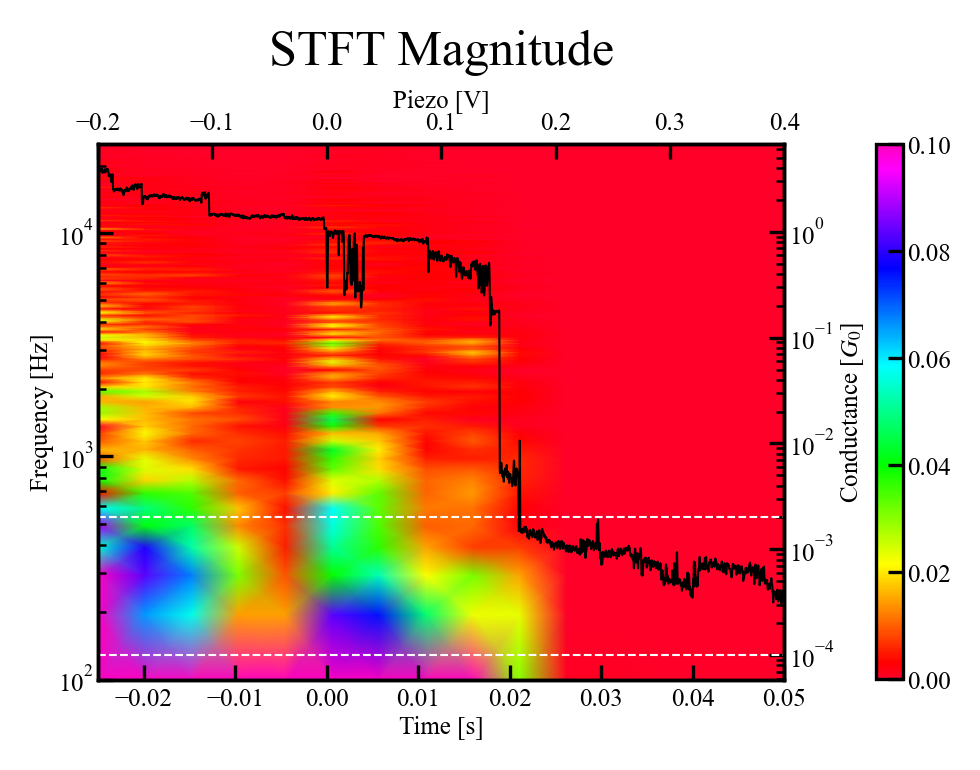

In [262]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
parx = ax.twinx()
pary = ax.twiny()

ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
pary.set_xlabel('Piezo [V]')
parx.set_ylabel(r'Conductance [$G_{0}$]')
ax.set_yscale('log')
ax.set_ylim(100, 25000)
print(ax.get_xlim())
parx.set_yscale('log')

ax.set_xlim(min(aligned_piezo_pull[ind])/piezo_rate, max(aligned_piezo_pull[ind])/piezo_rate)
shift=min(aligned_piezo_pull[ind])/piezo_rate
pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx), vmin=0, vmax=0.1, shading='gouraud', cmap='gist_rainbow', zorder=0)

pary.set_xlim(min(aligned_piezo_pull[ind]), max(aligned_piezo_pull[ind]))

parx.plot(aligned_piezo_pull[ind]/piezo_rate,
          aligned_cond_pull[ind], 'k', lw=0.5, zorder=100)


parx.axhline(2e-3, ls='--', lw='0.5', c='white')
parx.axhline(1e-4, ls='--', lw='0.5', c='white')

fig.colorbar(pcm, ax=pary, pad=0.1)

(0.0, 1.0)


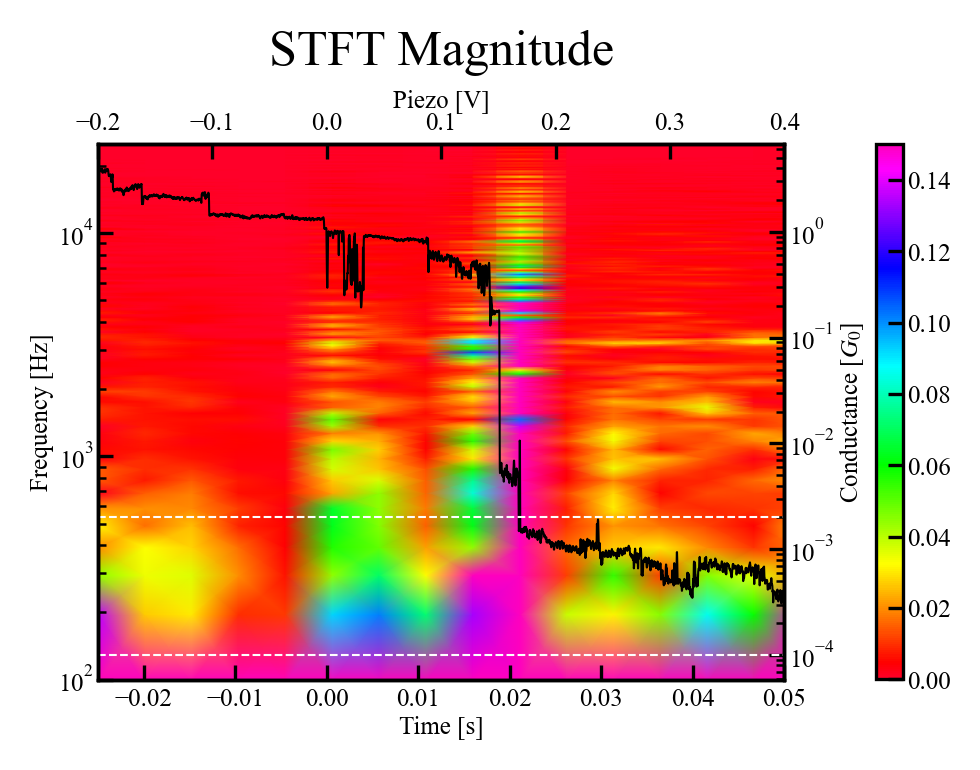

In [263]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
parx = ax.twinx()
pary = ax.twiny()

ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
pary.set_xlabel('Piezo [V]')
parx.set_ylabel(r'Conductance [$G_{0}$]')
ax.set_yscale('log')
ax.set_ylim(100, 25_000)
# ax.set_ylim(100, 10_000)
print(ax.get_xlim())
parx.set_yscale('log')

ax.set_xlim(min(aligned_piezo_pull[ind])/piezo_rate, max(aligned_piezo_pull[ind])/piezo_rate)
shift=min(aligned_piezo_pull[ind])/piezo_rate
pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx)/cond_avg, vmin=0, vmax=0.15, shading='gouraud', cmap='gist_rainbow')

pary.set_xlim(min(aligned_piezo_pull[ind]), max(aligned_piezo_pull[ind]))

parx.plot(aligned_piezo_pull[ind]/piezo_rate,
          aligned_cond_pull[ind], 'k', lw=0.5)


parx.axhline(2e-3, ls='--', lw='0.5', c='white')
parx.axhline(1e-4, ls='--', lw='0.5', c='white')

fig.colorbar(pcm, ax=pary, pad=0.1)

(0.0, 1.0)


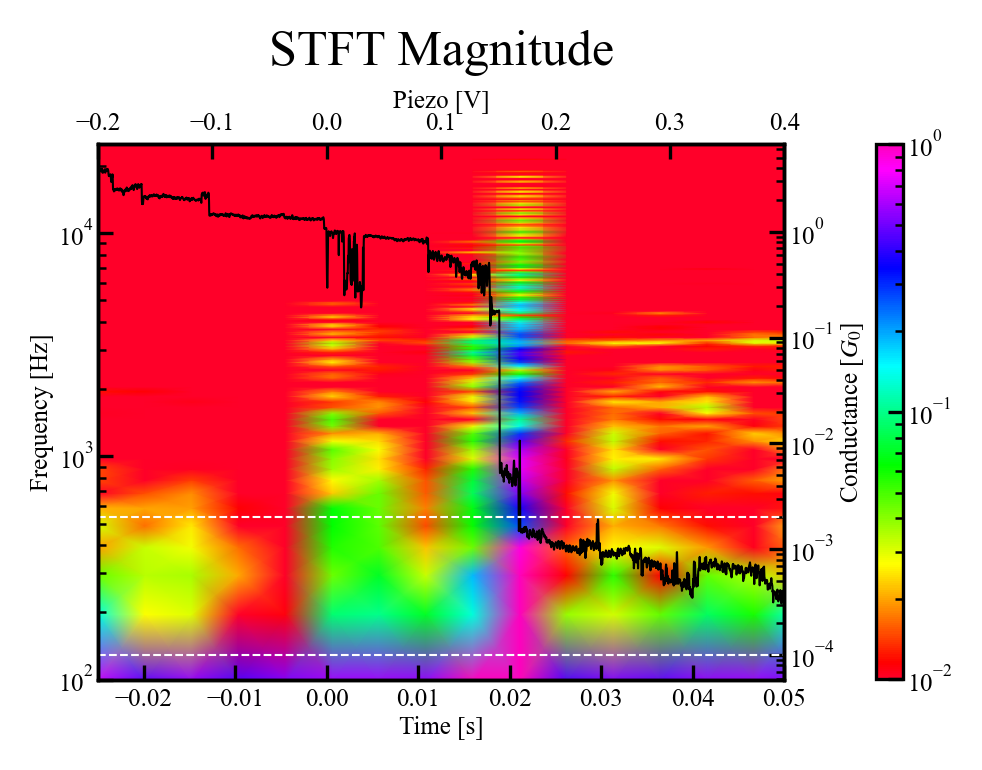

In [264]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
parx = ax.twinx()
pary = ax.twiny()

ax.set_title('STFT Magnitude') 
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
pary.set_xlabel('Piezo [V]')
parx.set_ylabel(r'Conductance [$G_{0}$]')
ax.set_yscale('log')
ax.set_ylim(100, 25_000)
# ax.set_ylim(100, 10_000)
print(ax.get_xlim())
parx.set_yscale('log')

ax.set_xlim(min(aligned_piezo_pull[ind])/piezo_rate, max(aligned_piezo_pull[ind])/piezo_rate)
shift=min(aligned_piezo_pull[ind])/piezo_rate
# pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx)/cond_avg, shading='gouraud', cmap='gist_rainbow',
#                     norm=LogNorm(vmin=np.abs(Zxx).min(), vmax=np.abs(Zxx).max()))

pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx)/cond_avg, shading='gouraud', cmap='gist_rainbow',
                    norm=LogNorm(vmin=1e-2, vmax=1))

pary.set_xlim(min(aligned_piezo_pull[ind]), max(aligned_piezo_pull[ind]))

parx.plot(aligned_piezo_pull[ind]/piezo_rate,
          aligned_cond_pull[ind], 'k', lw=0.5)


parx.axhline(2e-3, ls='--', lw='0.5', c='white')
parx.axhline(1e-4, ls='--', lw='0.5', c='white')

fig.colorbar(pcm, ax=pary, pad=0.1)

In [68]:
Zxx.shape[1]

16

In [69]:
cond_avg.shape

(16,)

In [70]:
colors = pl.cm.gist_rainbow(np.linspace(0, 1, num=Zxx.shape[1]))

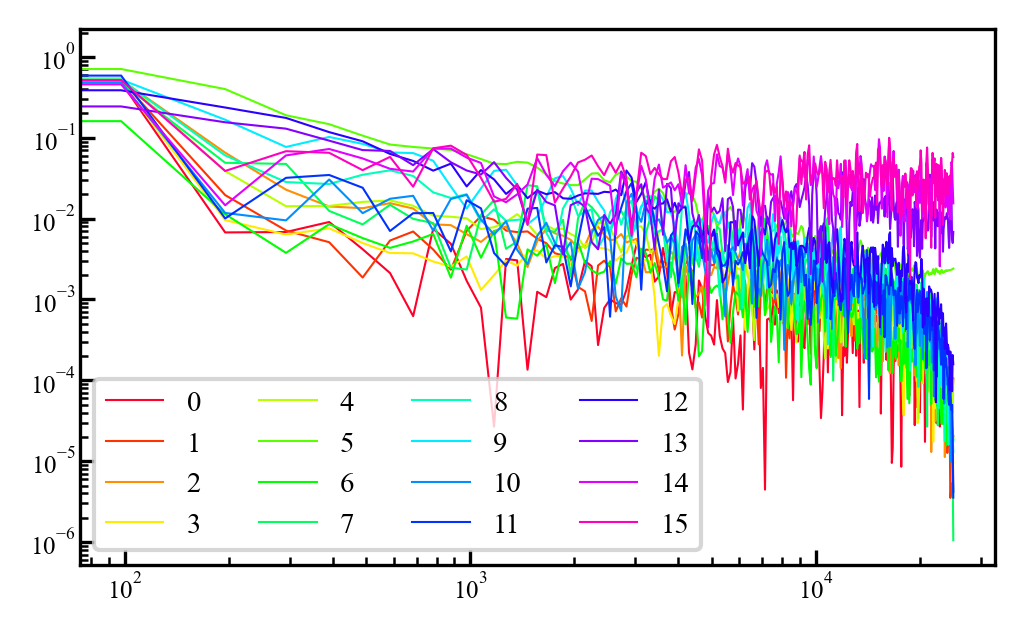

In [71]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height

j=0
for i in range(0, Zxx.shape[1], 1):
    ax.plot(f, np.abs(Zxx)[:,i]/cond_avg[i], label=str(i), lw=0.5,c=colors[j])
    j+=1
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize='x-small', ncol=4)

### Push

In [272]:
ind_push = np.random.choice(selected_push.shape[0])
ind_push = 3345

In [273]:
win_size = 512
step_size = win_size//2

cond_avg = mov_avg(aligned_cond_push[ind_push], win_size=win_size, step_size=step_size, avg_type=log_avg)

f, t, Zxx = scipy.signal.stft(aligned_cond_push[ind_push], fs=50_000, window='hann', nperseg=win_size,
                              noverlap=win_size-step_size,nfft=None, detrend=False, return_onesided=True,
                              boundary='even', padded=True, axis=- 1)

(0.0, 1.0)


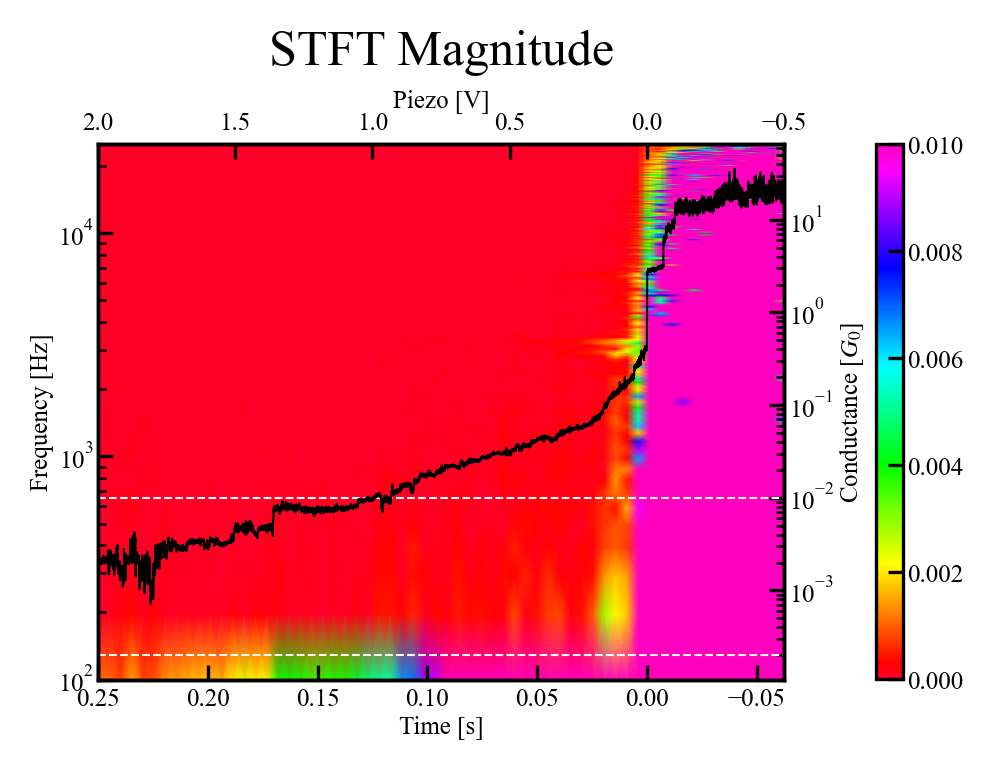

In [274]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
parx = ax.twinx()
pary = ax.twiny()

ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
pary.set_xlabel('Piezo [V]')
parx.set_ylabel(r'Conductance [$G_{0}$]')
ax.set_yscale('log')
ax.set_ylim(100, 25000)
print(ax.get_xlim())
parx.set_yscale('log')

ax.set_xlim(max(aligned_piezo_push[ind_push])/piezo_rate, min(aligned_piezo_push[ind_push])/piezo_rate)
shift=min(aligned_piezo_push[ind_push])/piezo_rate
pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx), vmin=0, vmax=0.01, shading='gouraud', cmap='gist_rainbow', zorder=0)

pary.set_xlim(max(aligned_piezo_push[ind_push]), min(aligned_piezo_push[ind_push]))

parx.plot(aligned_piezo_push[ind_push]/piezo_rate,
          aligned_cond_push[ind_push], 'k', lw=0.5, zorder=100)


parx.axhline(2e-4, ls='--', lw='0.5', c='white')
parx.axhline(1e-2, ls='--', lw='0.5', c='white')

fig.colorbar(pcm, ax=pary, pad=0.1)

(0.0, 1.0)


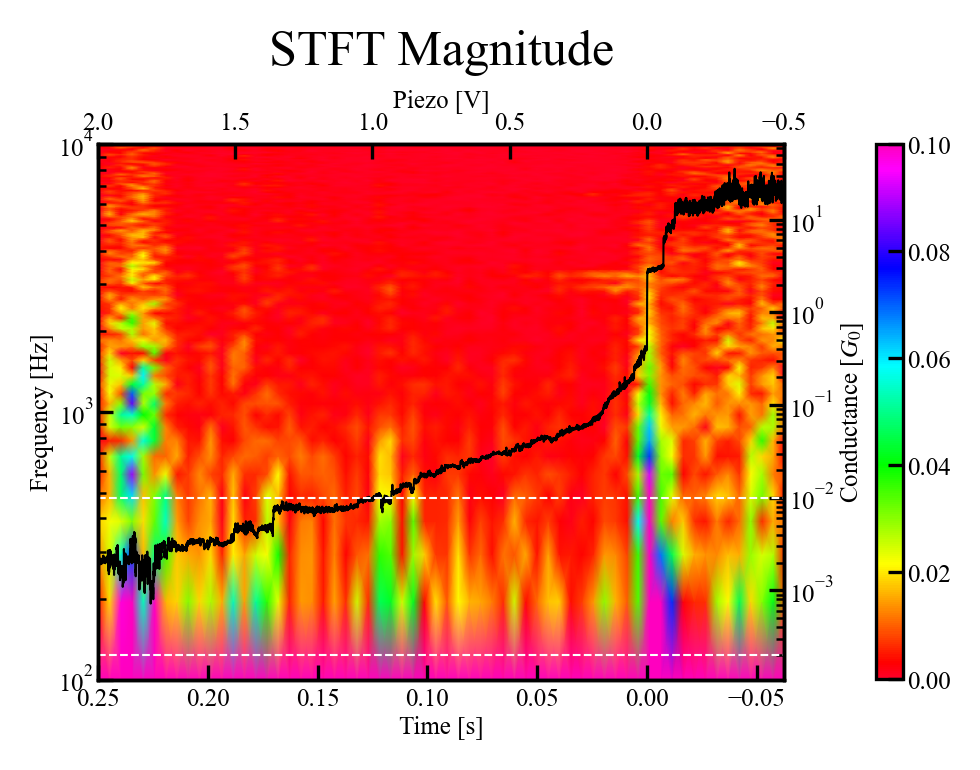

In [275]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
parx = ax.twinx()
pary = ax.twiny()

ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
pary.set_xlabel('Piezo [V]')
parx.set_ylabel(r'Conductance [$G_{0}$]')
ax.set_yscale('log')
ax.set_ylim(100, 25_000)
ax.set_ylim(100, 10_000)
print(ax.get_xlim())
parx.set_yscale('log')

ax.set_xlim(max(aligned_piezo_push[ind_push])/piezo_rate, min(aligned_piezo_push[ind_push])/piezo_rate)
shift=min(aligned_piezo_push[ind_push])/piezo_rate
pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx)/cond_avg, vmin=0, vmax=0.1, shading='gouraud', cmap='gist_rainbow')

pary.set_xlim(max(aligned_piezo_push[ind_push]), min(aligned_piezo_push[ind_push]))

parx.plot(aligned_piezo_push[ind_push]/piezo_rate,
          aligned_cond_push[ind_push], 'k', lw=0.5)


parx.axhline(2e-4, ls='--', lw='0.5', c='white')
parx.axhline(1e-2, ls='--', lw='0.5', c='white')

fig.colorbar(pcm, ax=pary, pad=0.1)

(0.0, 1.0)


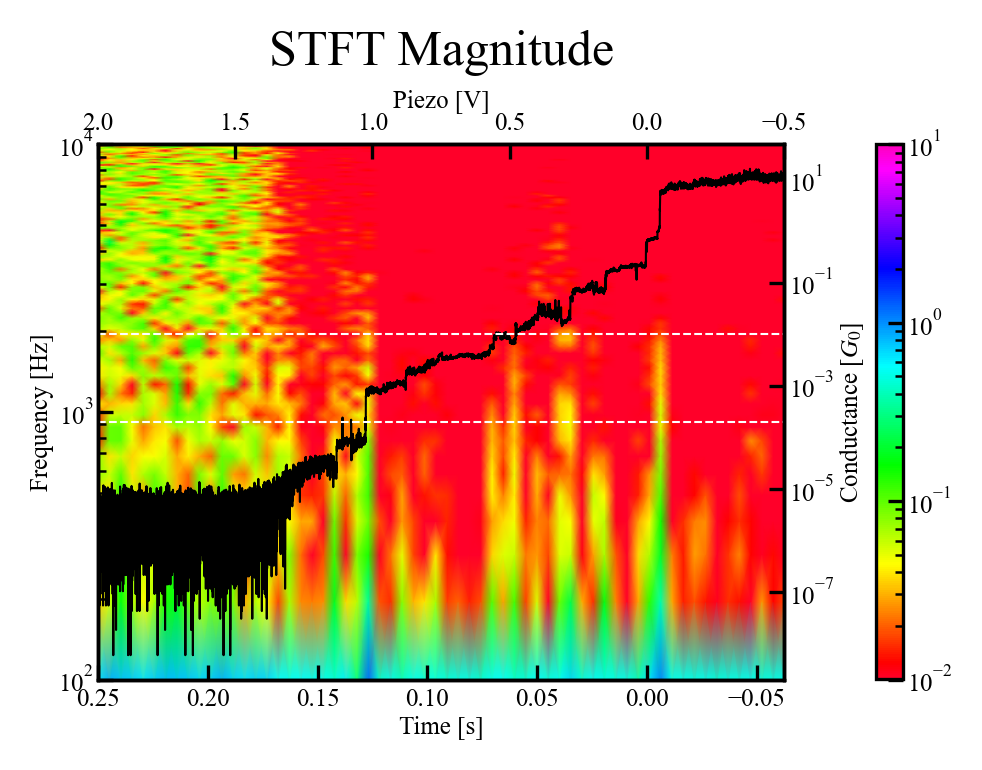

In [76]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
parx = ax.twinx()
pary = ax.twiny()

ax.set_title('STFT Magnitude')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
pary.set_xlabel('Piezo [V]')
parx.set_ylabel(r'Conductance [$G_{0}$]')
ax.set_yscale('log')
ax.set_ylim(100, 25_000)
ax.set_ylim(100, 10_000)
print(ax.get_xlim())
parx.set_yscale('log')

ax.set_xlim(max(aligned_piezo_push[ind_push])/piezo_rate, min(aligned_piezo_push[ind_push])/piezo_rate)
shift=min(aligned_piezo_push[ind_push])/piezo_rate
pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx)/cond_avg, shading='gouraud', cmap='gist_rainbow',
                    norm=LogNorm(vmin=1e-2, vmax=10))

pary.set_xlim(max(aligned_piezo_push[ind_push]), min(aligned_piezo_push[ind_push]))

parx.plot(aligned_piezo_push[ind_push]/piezo_rate,
          aligned_cond_push[ind_push], 'k', lw=0.5)


parx.axhline(2e-4, ls='--', lw='0.5', c='white')
parx.axhline(1e-2, ls='--', lw='0.5', c='white')

fig.colorbar(pcm, ax=pary, pad=0.1)

In [77]:
Zxx.shape[1]

63

In [78]:
cond_avg.shape

(63,)

In [79]:
colors = pl.cm.gist_rainbow(np.linspace(0, 1, num=Zxx.shape[1]))

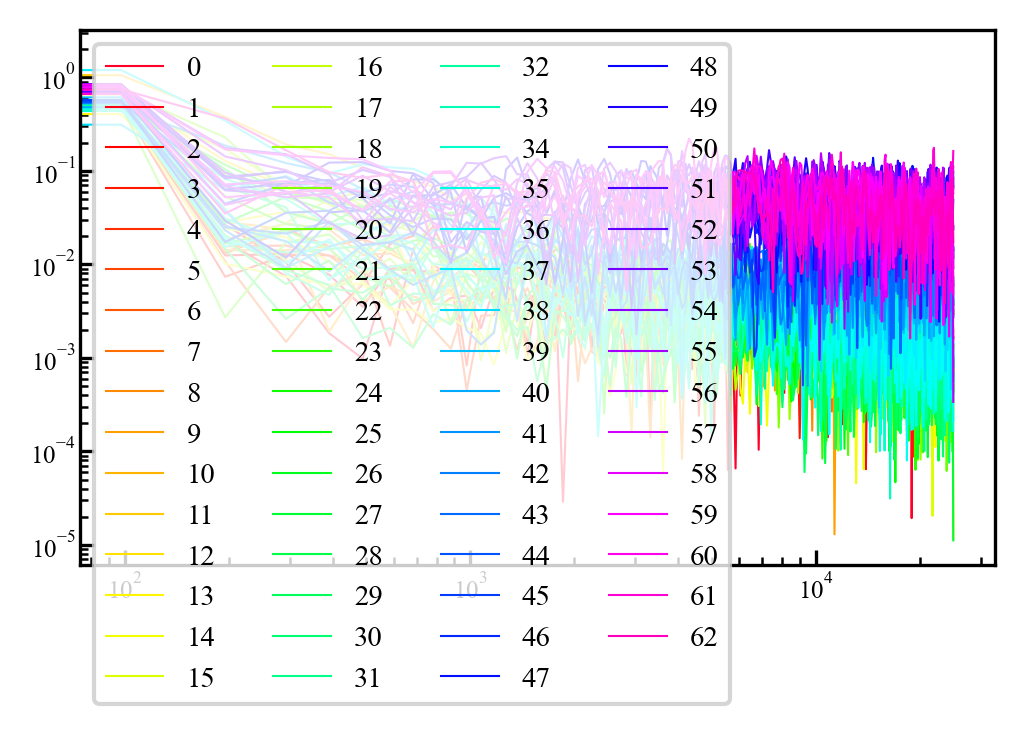

In [80]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height

j=0
for i in range(0, Zxx.shape[1], 1):
    ax.plot(f, np.abs(Zxx)[:,i]/cond_avg[i], label=str(i), lw=0.5,c=colors[j])
    j+=1
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize='x-small', ncol=4)

## Cut out molecular plateau

In [96]:
pull_mol_range = (1e-4, 2e-3)
push_mol_range = (2e-4, 1e-2)

In [97]:
selected_pull[0]

36006

In [245]:
trace_pair = TracePair(selected_pull[75], load_from=home_folder)

In [246]:
trace_pair.conductance_pull

array([1.7355417e+01, 1.6648630e+01, 2.7212366e+01, ..., 1.7038055e-06,
       5.5910705e-06, 1.5928448e-06], dtype=float32)

In [100]:
aligned_cond_pull[0]

array([3.3689361e+00, 3.3653831e+00, 3.6268117e+00, ..., 5.9646499e-07,
       3.8565340e-06, 3.0938450e-06], dtype=float32)

In [276]:
mol_start = np.where(aligned_cond_pull[0] > pull_mol_range[1])[0][-1]
mol_end = np.where(aligned_cond_pull[0] < pull_mol_range[0])[0][0]

print(mol_start, mol_end, mol_end-mol_start-1)
plateau_cond_pull = aligned_cond_pull[0][mol_start+1:mol_end]
plateau_piezo_pull = aligned_piezo_pull[0][mol_start+1:mol_end]

# mol_start = np.where(aligned_cond_push[0] > push_mol_range[1])[0][-1]
# mol_end = np.where(aligned_cond_push[0] < push_mol_range[0])[0][0]

# print(mol_start, mol_end, mol_end-mol_start-1)

mol_start = np.where(aligned_cond_push[3345][::-1] > push_mol_range[1])[0][0]
mol_end = np.where(aligned_cond_push[3345][::-1] < push_mol_range[0])[0][-1]

print(mol_start, mol_end, mol_start-mol_end-1)
plateau_cond_push = aligned_cond_push[3345][::-1][mol_end+1:mol_start]
plateau_piezo_push = aligned_piezo_push[3345][::-1][mol_end+1:mol_start]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [109]:
win_size = 512
step_size = win_size//2

cond_avg = mov_avg(plateau_cond_pull, win_size=win_size, step_size=step_size, avg_type=log_avg)

f, t, Zxx = scipy.signal.stft(plateau_cond_pull, fs=50_000, window='hann', nperseg=win_size,
                              noverlap=win_size-step_size,nfft=None, detrend=False, return_onesided=True,
                              boundary='even', padded=True, axis=- 1)

(0.0, 1.0)


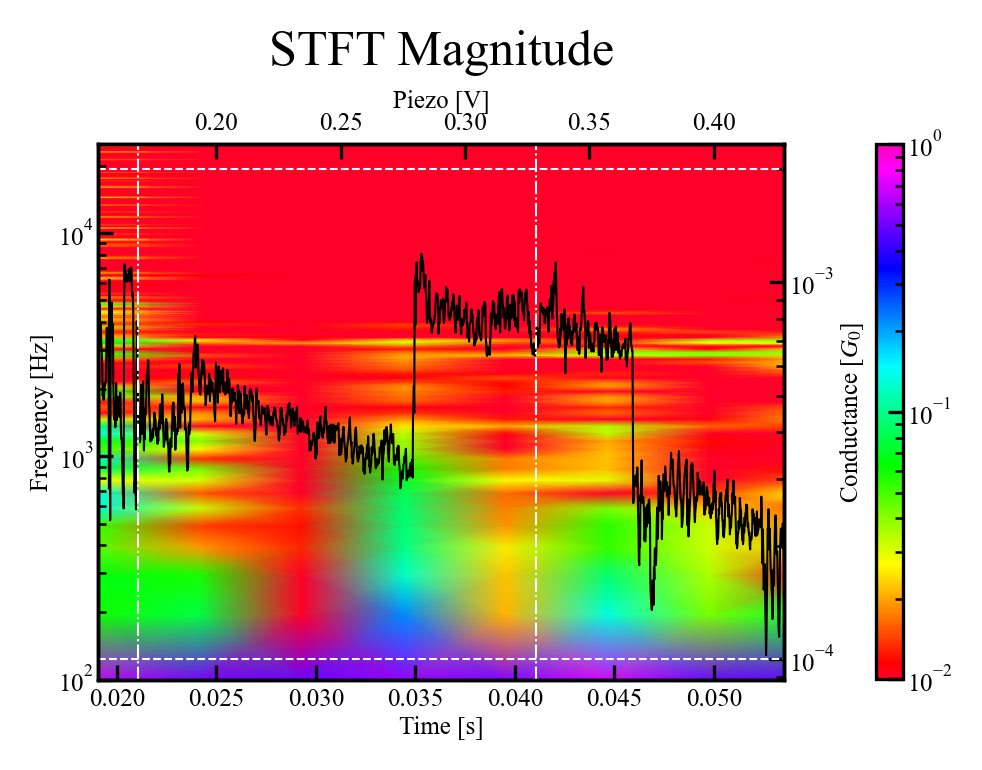

In [126]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
parx = ax.twinx()
pary = ax.twiny()

ax.set_title('STFT Magnitude') 
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
pary.set_xlabel('Piezo [V]')
parx.set_ylabel(r'Conductance [$G_{0}$]')
ax.set_yscale('log')
ax.set_ylim(100, 25_000)
# ax.set_ylim(100, 10_000)
print(ax.get_xlim())
parx.set_yscale('log')

ax.set_xlim(min(plateau_piezo_pull)/piezo_rate, max(plateau_piezo_pull)/piezo_rate)
shift=min(plateau_piezo_pull)/piezo_rate
# pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx)/cond_avg, shading='gouraud', cmap='gist_rainbow',
#                     norm=LogNorm(vmin=np.abs(Zxx).min(), vmax=np.abs(Zxx).max()))

pcm = ax.pcolormesh(t+shift, f, np.abs(Zxx)/cond_avg, shading='gouraud', cmap='gist_rainbow',
                    norm=LogNorm(vmin=1e-2, vmax=1))

pary.set_xlim(min(plateau_piezo_pull), max(plateau_piezo_pull))

parx.plot(plateau_piezo_pull/piezo_rate,
          plateau_cond_pull, 'k', lw=0.5)

parx.axvline((plateau_piezo_pull/piezo_rate)[100], ls='-.', lw='0.5', c='white')
parx.axvline((plateau_piezo_pull/piezo_rate)[100+1001], ls='-.', lw='0.5', c='white')


parx.axhline(2e-3, ls='--', lw='0.5', c='white')
parx.axhline(1e-4, ls='--', lw='0.5', c='white')

fig.colorbar(pcm, ax=pary, pad=0.1)

In [277]:
# plat_cond_pull_list = []
# plat_piez_pull_list = []
# plat_cond_push_list = []
# plat_piez_push_list = []

# for i in range(len(selected_pull)):
#     mol_start = np.where(aligned_cond_pull[i] > pull_mol_range[1])[0][-1]
# #         mol_end = np.where(aligned_cond < pull_mol_range[0])[0][0]

# #     print(mol_start, mol_end, mol_end-mol_start-1)
#     if len(aligned_cond_pull[i][mol_start+1:mol_start+1+1500]) == 1500:
#         plat_cond_pull_list.append(aligned_cond_pull[i][mol_start+1:mol_start+1+1500])
#         plat_piez_pull_list.append(aligned_cond_pull[i][mol_start+1:mol_start+1+1500])
#     else:
#         # skip
#         print(i)
        
# plat_cond_push_list = []
# plat_piez_push_list = []

# for i in range(len(selected_push)):
#     try:
#         mol_start = np.where(aligned_cond_push[i][::-1] < push_mol_range[0])[0][-1]
#     #         mol_end = np.where(aligned_cond < pull_mol_range[0])[0][0]

#     #     print(mol_start, mol_end, mol_end-mol_start-1)
#         if len(aligned_cond_push[i][::-1][mol_start+1:mol_start+1+1500]) == 1500:

#                 plat_cond_push_list.append(aligned_cond_push[i][::-1][mol_start+1:mol_start+1+1500])
#                 plat_piez_push_list.append(aligned_cond_push[i][::-1][mol_start+1:mol_start+1+1500])
#         else:
#             # skip
#             print(i)
#     except IndexError:
#         print(i)

In [ ]:
def bj_temporal_noise(traces,
                      window_size: int = 501,
                      step_size: int = 25,
                      align_at: float = 0.5,
                      plateau_length: int = 1500,
                      frequency_range: Tuple[int, int] = (100, 1000))

In [556]:
aligned_cond_pull[0][aligned_piezo_pull[0] > 0].shape

(2502,)

In [47]:
cond_pull = []
piez_pull = []
for i in range(len(selected_pull)):
    cond_pull.append(aligned_cond_pull[i][np.where(aligned_piezo_pull[i] > 0)[0][0]-1500 :
                                          np.where(aligned_piezo_pull[i] > 0)[0][0]])
    piez_pull.append(aligned_piezo_pull[i][np.where(aligned_piezo_pull[i] > 0)[0][0]-1500 :
                                           np.where(aligned_piezo_pull[i] > 0)[0][0]])
    
# cond_push = []
# piez_push = []
# for i in range(len(selected_push)):
#     cond_push.append(aligned_cond_push[i][np.where(aligned_piezo_push[i] > 0.05)[0][0] :
#                                        np.where(aligned_piezo_push[i] > 0.05)[0][0]+12500])
#     piez_push.append(aligned_piezo_push[i][np.where(aligned_piezo_push[i] > 0.05)[0][0] :
#                                        np.where(aligned_piezo_push[i] > 0.05)[0][0]+12500])

In [48]:
list(map(len, piez_pull))

[1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,
 1500,

In [49]:
win_size=501
step_size=25


In [50]:
len(cond_pull[0])//step_size

60

In [51]:
areas_pull = np.zeros((selected_pull.shape[0], len(cond_pull[0])//step_size))
cond_avg_in_win_pull = np.zeros((selected_pull.shape[0], len(cond_pull[0])//step_size))
psd_all = []

for trace in range(len(selected_pull)):

    mirr_ext_plat_piezo_pull = even_ext(piez_pull[trace], n=win_size//2)
    mirr_ext_plat_cond_pull = even_ext(cond_pull[trace], n=win_size//2)

    psd_intervals = np.array([mirr_ext_plat_cond_pull[i*step_size: i*step_size+win_size]
                              for i in range(len(cond_pull[trace])//step_size)])

    cond_avg_in_win_pull[trace] = np.array(list(map(log_avg, psd_intervals)))
    
    fft_freqs, psd_results = scipy.signal.welch(x=psd_intervals, fs=50_000, window='hann',
                                                nperseg=win_size, noverlap=0, nfft=None,
                                                detrend=False, scaling='density', average='mean', axis=1)
    psd_all.append(psd_results)
    
    mask = np.bitwise_and(fft_freqs > 2000, fft_freqs < 5000)

    for i, psd_result in enumerate(psd_results):
        areas_pull[trace, i] = scipy.integrate.trapz(psd_result[mask], x=fft_freqs[mask])

psd_all = np.array(psd_all)

n_pull = np.zeros(psd_intervals.shape[0])

multiplier = utils.Constants.r0 ** 2 / (trace_pair.bias_mv/1000) ** 2
noise_power_pull = areas_pull  # g0**2
conductance_noise_pull = np.sqrt(areas_pull) / cond_avg_in_win_pull  # unitless

N = np.linspace(0, 4, num=1000)
for interval in range(psd_intervals.shape[0]):
    pull_corr = np.zeros_like(N)
    for i, n in enumerate(N):
        pull_corr[i] = utils.calc_correlation(np.log10(noise_power_pull[:, interval]/cond_avg_in_win_pull[:, interval]**n),
                                              np.log10(cond_avg_in_win_pull[:, interval]))
        
    n_pull[interval] = N[abs(pull_corr) == min(abs(pull_corr))][0]

# plots.plot_correlation(N, pull_corr)

(<AxesSubplot:xlabel='$n$', ylabel='$C(\\log(iPSD/G_{\\mathrm{avg}}^{n}), \\log(G_{\\mathrm{avg}}))$'>,
 1.7577577577577577)

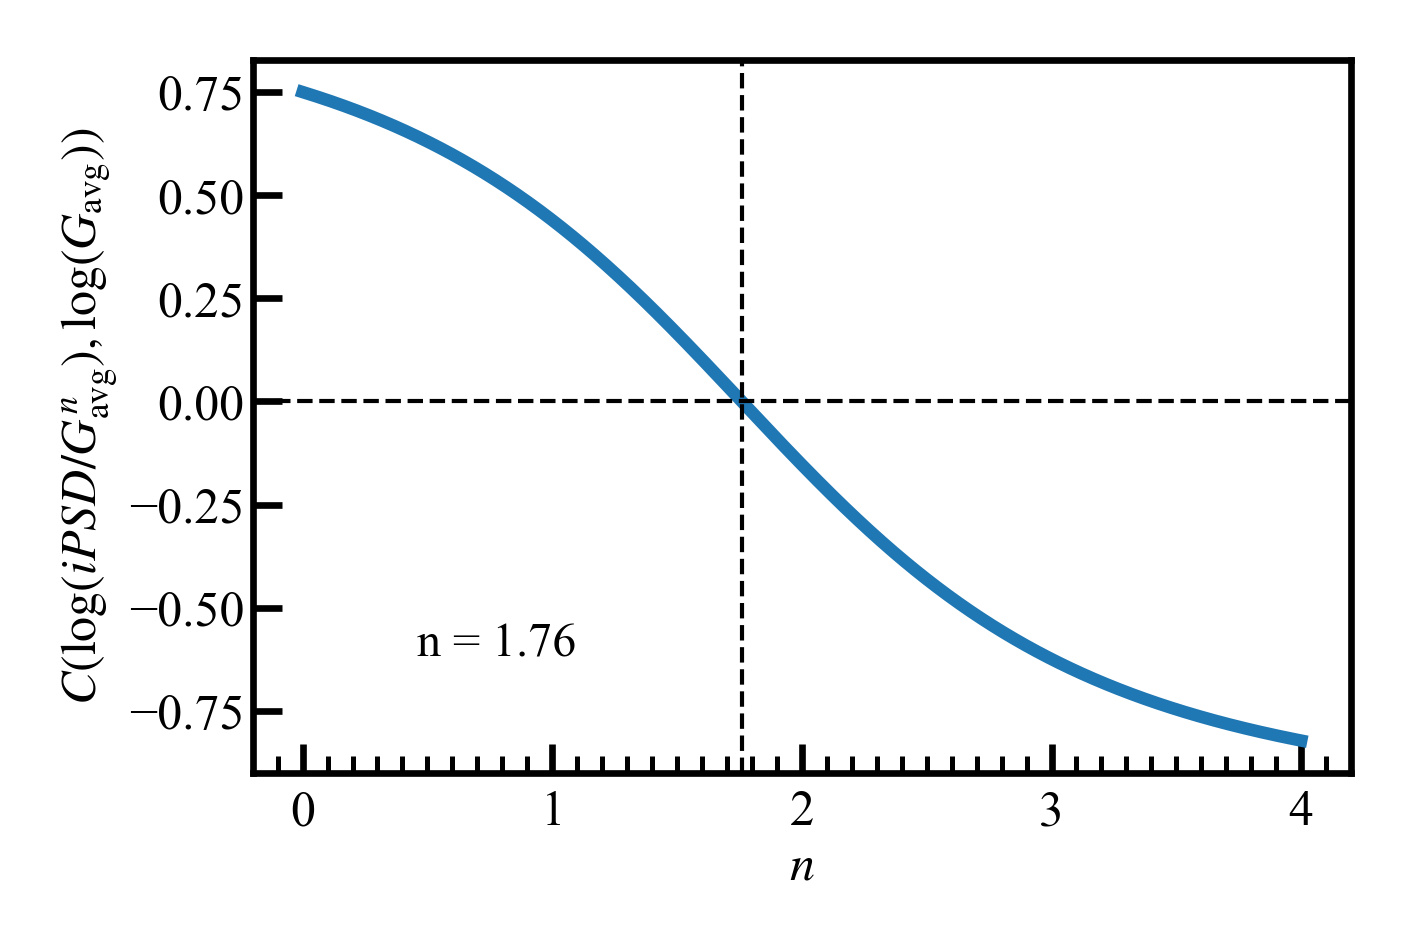

In [37]:
N = np.linspace(0, 4, num=1000)
interval=65
pull_corr = np.zeros_like(N)
for i, n in enumerate(N):
    pull_corr[i] = utils.calc_correlation(np.log10(noise_power_pull[:, interval]/cond_avg_in_win_pull[:, interval]**n),
                                          np.log10(cond_avg_in_win_pull[:, interval]))

n_pull[interval] = N[abs(pull_corr) == min(abs(pull_corr))][0]

plots.plot_correlation(N, pull_corr)

In [38]:
max(areas_pull.flatten())

1.25082308345636

In [39]:
n_pull

array([1.42942943, 1.43743744, 1.44944945, 1.47347347, 1.4974975 ,
       1.51751752, 1.52952953, 1.53353353, 1.52952953, 1.52952953,
       1.53353353, 1.52952953, 1.54554555, 1.56556557, 1.57757758,
       1.57357357, 1.55355355, 1.53753754, 1.53753754, 1.54554555,
       1.58558559, 1.61761762, 1.68968969, 1.77777778, 1.87387387,
       1.95395395, 2.04604605, 2.17017017, 2.33033033, 2.48248248,
       2.65465465, 2.86286286, 3.08708709, 3.33133133, 3.55555556,
       3.7997998 , 4.        , 4.        , 4.        , 4.        ,
       4.        , 4.        , 4.        , 4.        , 3.65565566,
       3.17517518, 2.61061061, 2.1981982 , 1.98198198, 1.94594595,
       1.95395395, 1.95795796, 1.90590591, 1.86186186, 1.82982983,
       1.80580581, 1.78578579, 1.76576577, 1.75775776, 1.75775776,
       1.76976977, 1.77377377, 1.77377377, 1.76576577, 1.75775776,
       1.75775776, 1.76176176, 1.75375375, 1.74574575, 1.74174174,
       1.74974975, 1.75775776, 1.76176176, 1.75775776, 1.74574

In [16]:
hist_selected = Histogram(home_folder, traces=selected_pull)

hist_selected.calc_stats(align_at=1e-5, range_pull=(-0.6, 0.2), range_push=(-1, 2), xbins_pull=250, xbins_push=400,
                plateau_length_bins=100)

  0%|          | 0/157 [00:00<?, ?it/s]

Pull 2D histogram created from 157 traces
Push 2D histogram created from 157 traces


In [570]:
piez_pull[0].shape[0]//25

100

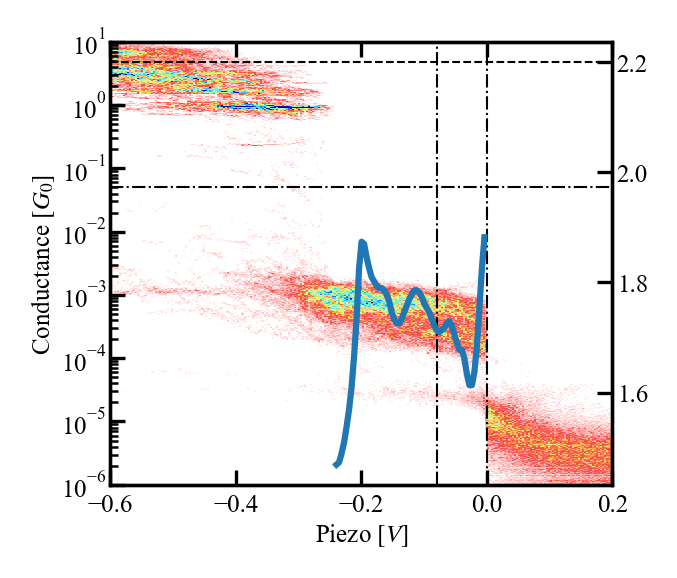

In [53]:
# fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height
# ax.plot(n_pull)

ax = hist_selected.plot_hist_2d_one(direction='pull', dpi=300, vmax=100)
parx=ax.twinx()

parx.plot(piez_pull[0][::25], n_pull)
# parx.scatter(piez_pull[0][::25][65], n_pull[65], c='r', s=1)

ax.axhline(0.05, ls='-.', lw=0.5, c='k')
parx.axhline(2.2, ls='--', lw=0.5, c='k')

ax.axvline(piez_pull[0][-501], ls='-.', lw=0.5, c='k')
ax.axvline(piez_pull[0][-1], ls='-.', lw=0.5, c='k')

In [45]:
piez_pull[0][-1]

-0.08003996003995617

<AxesSubplot:xlabel='Piezo [V]', ylabel='Conductance [$G_{0}$]'>

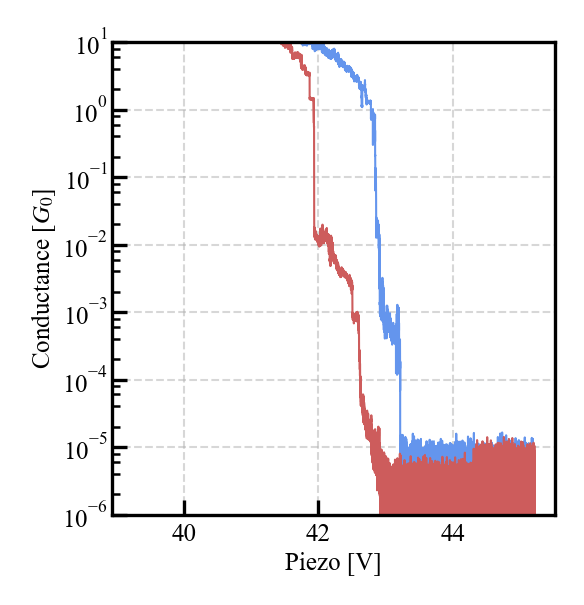

In [54]:
which_trace = np.random.choice(selected_pull)
trace_pair = TracePair(which_trace, load_from=home_folder)

trace_pair.plot_trace_pair(dpi=300)

In [437]:
max(noise_power_pull[:, interval])

1463483056.3594203

<AxesSubplot:xlabel='$\\langle G \\rangle [G_0]$'>

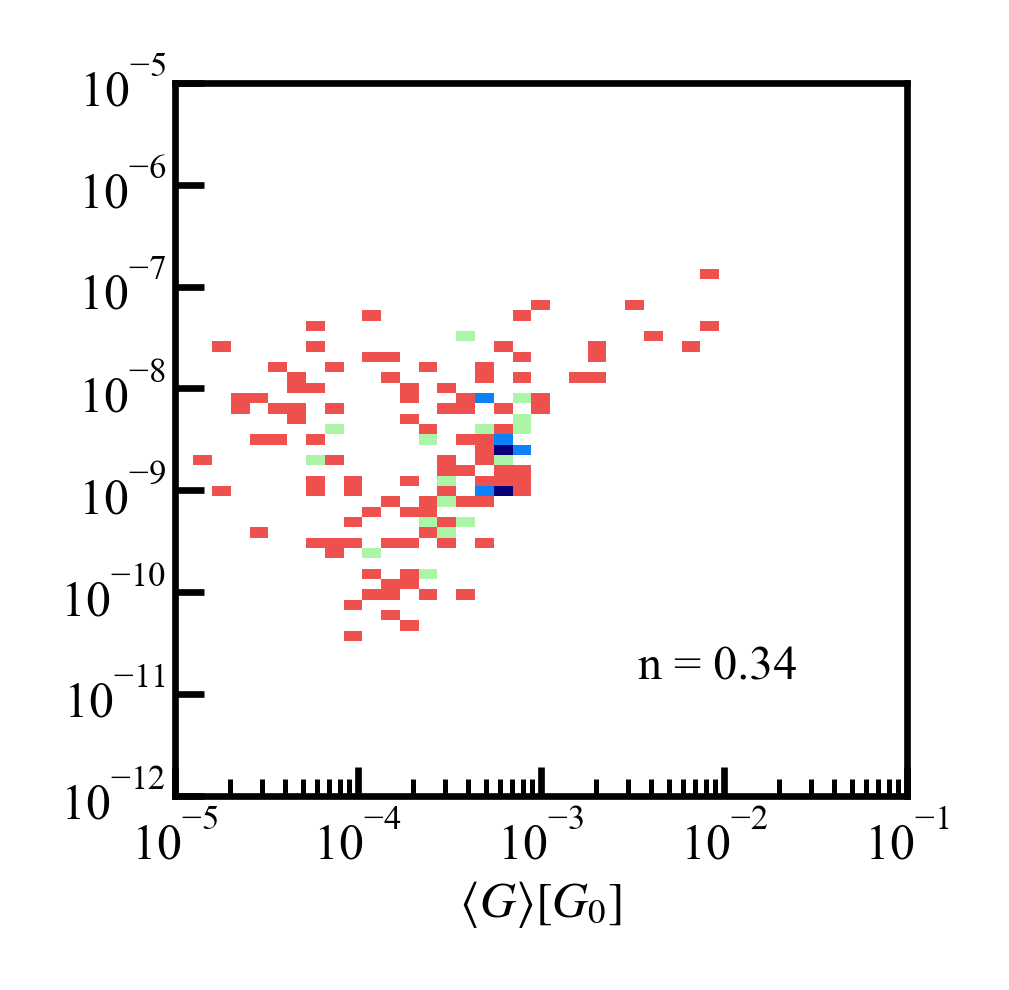

In [572]:
interval = 65

plots.plot_noise_po wer_2dhist(conductance_avgs=cond_avg_in_win_pull[:, interval], noise_power=noise_power_pull[:, interval], n=n_pull[interval],
                            xrange=(1e-5, 0.1),
                            num_bins=(10, 10),
                            shift=0,
                            axis=None, cmap=utils.cmap_geo32)

In [416]:
selected_pull

array([36006, 36063, 36078, 36116, 36118, 36126, 36135, 36192, 36201,
       36205, 36248, 36249, 36276, 36277, 36371, 36416, 36469, 36505,
       36558, 36569, 36618, 36625, 36641, 36642, 36658, 36675, 36679,
       36691, 36716, 36755, 36812, 36855, 36869, 36877, 36973, 36998,
       37011, 37019, 37028, 37084, 37194, 37204, 37210, 37412, 37541,
       37625, 37941, 37959, 38010, 38061, 38194, 38202, 38226, 38311,
       38314, 38334, 38348, 38441, 38516, 38587, 38645, 38655, 38780,
       38984, 39080, 39147, 39180, 39231, 39303, 39346, 39350, 39403,
       39443, 39445, 39459, 39460, 39463, 39464, 39467, 39468, 39470,
       39472, 39478, 39586, 39635, 39695, 39706, 39722, 39748, 39757,
       39893, 39894, 39912, 39938, 39950, 40015, 40043, 40068, 40095,
       40111, 40123, 40161, 40168, 40235, 40322, 40407, 40433, 40438,
       40495, 40514, 40584, 40601, 40624, 40655, 40662, 40681, 40684,
       41095, 41162, 41163, 41211, 41223, 41227, 41262, 41263, 41295,
       41317, 41323,

In [411]:
piez_pull[0][::25].shape

(100,)

In [394]:
cond_avg_in_win_pull

array([[2.88977208e-03, 2.88535251e-03, 2.87906298e-03, ...,
        4.90632240e-04, 4.90586992e-04, 4.89868966e-04],
       [1.14995505e-03, 1.14848128e-03, 1.14828521e-03, ...,
        1.11210165e-05, 1.10502392e-05, 1.10206145e-05],
       [7.42626240e-01, 7.42395449e-01, 7.41433671e-01, ...,
        5.76996909e-04, 5.82973218e-04, 5.86788686e-04],
       ...,
       [5.34995247e-03, 5.31802296e-03, 5.22892484e-03, ...,
        2.16077244e-06, 2.18373063e-06, 2.19829915e-06],
       [1.82680239e-02, 1.82419226e-02, 1.80404911e-02, ...,
        1.20880823e-05, 1.21201905e-05, 1.21579225e-05],
       [9.14856680e-04, 9.15533946e-04, 9.12939142e-04, ...,
        3.94540642e-06, 3.66039591e-06, 3.77283891e-06]])

In [396]:
psd_intervals.shape

(100, 1001)

In [378]:
areas_pull.shape

(157, 100)

In [504]:
mask = np.bitwise_and(fft_freqs > 100, fft_freqs < 1000)
area = scipy.integrate.trapz(psd_all[0, 40, :][mask], x=fft_freqs[mask])

In [505]:
area

3.2917929037300378e-09

In [500]:
area = scipy.integrate.trapz(np.ones_like(fft_freqs[mask])*1e-11, x=fft_freqs[mask])

In [501]:
area

8.491508491508491e-09

In [444]:
psd_results.shape

(100, 501)

In [448]:
psd_all.shape

(157, 100, 501)

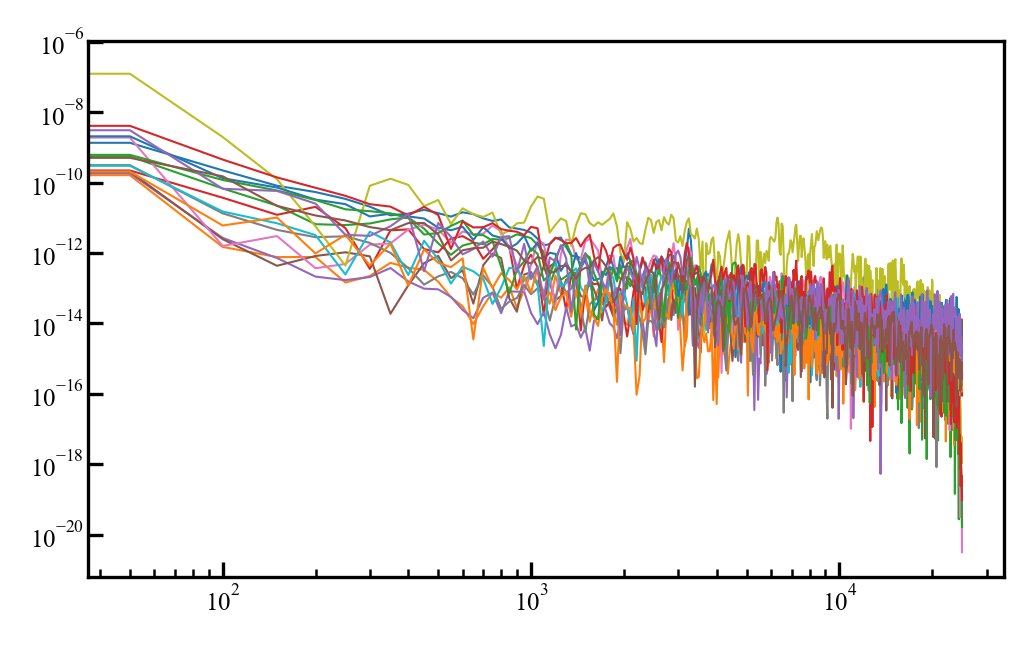

In [538]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height

for i in range(0, psd_all.shape[0], 10):
    ax.plot(fft_freqs, psd_all[i, 65, :], label=str(i), lw=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.legend(fontsize='x-small', ncol=4)

In [539]:
noise_power_pull[0, 65]

1.4422967010095158e-08

In [497]:
noise_power_pull.shape

(157, 48)

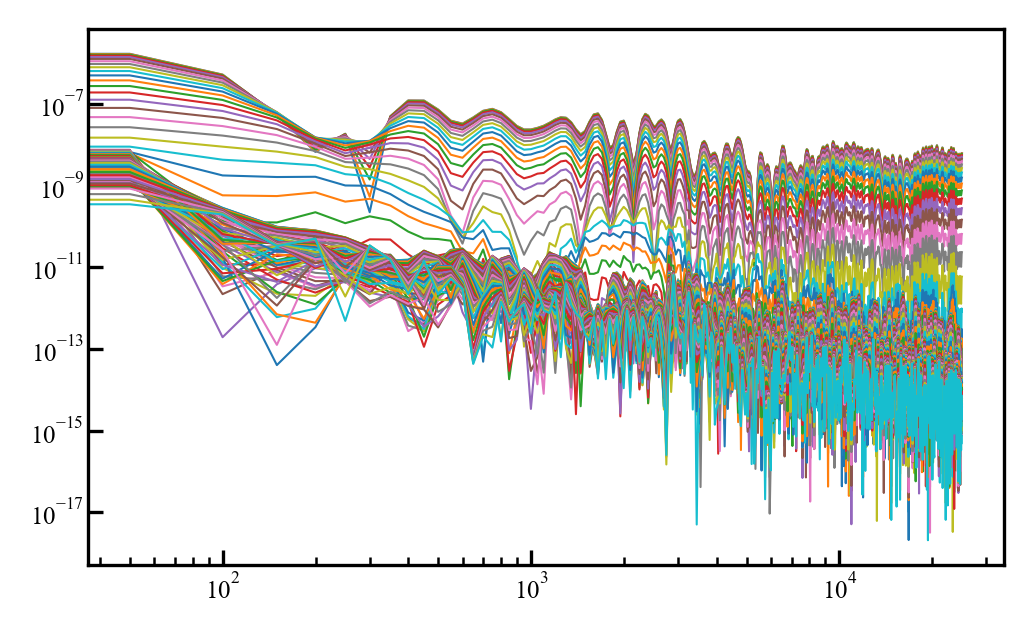

In [449]:
fig, ax = plt.subplots(1, figsize=utils.cm2inch(10, 6), dpi=300)  # width, height

for i in range(psd_results.shape[0]):
    ax.plot(fft_freqs, psd_all[0, i], label=str(i), lw=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.legend(fontsize='x-small', ncol=4)

In [446]:
psd_intervals.shape

(100, 1001)